In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0.dev0


# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements, and eventually radial velocity measurements (in the next tutorial, :ref:`astrometric-rv`). For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi/180.
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

# Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


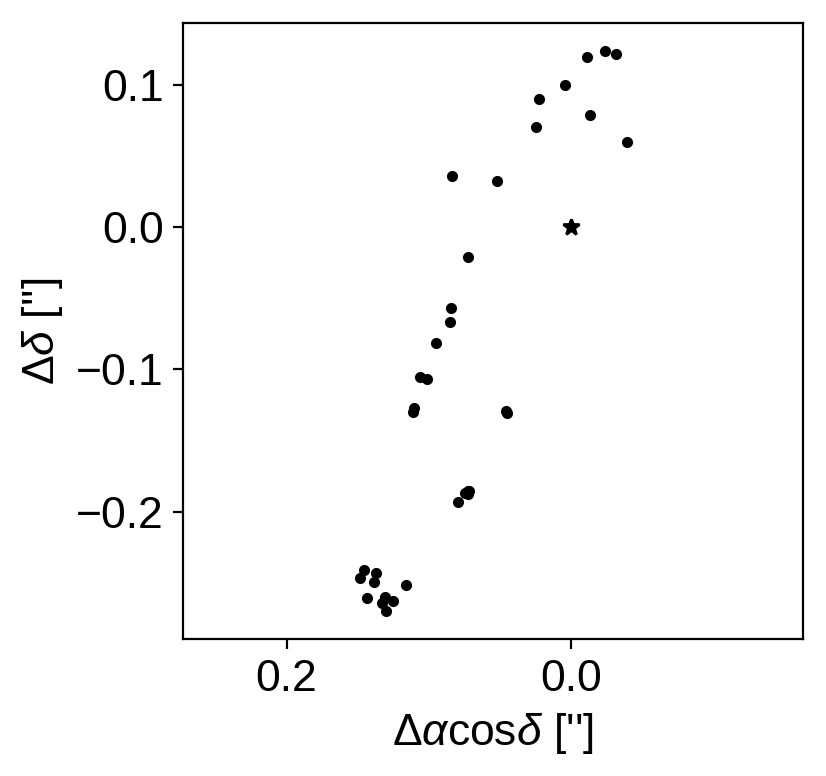

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

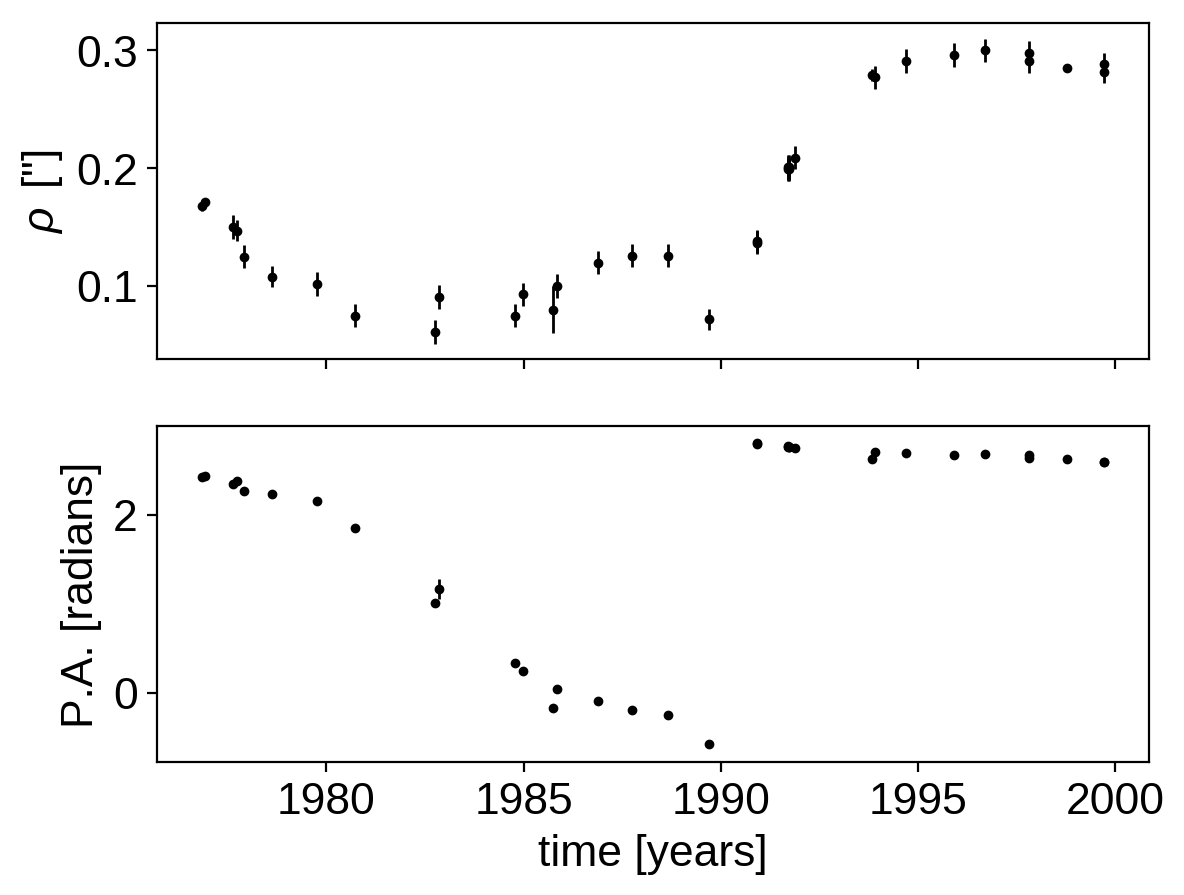

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [years]");

# Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

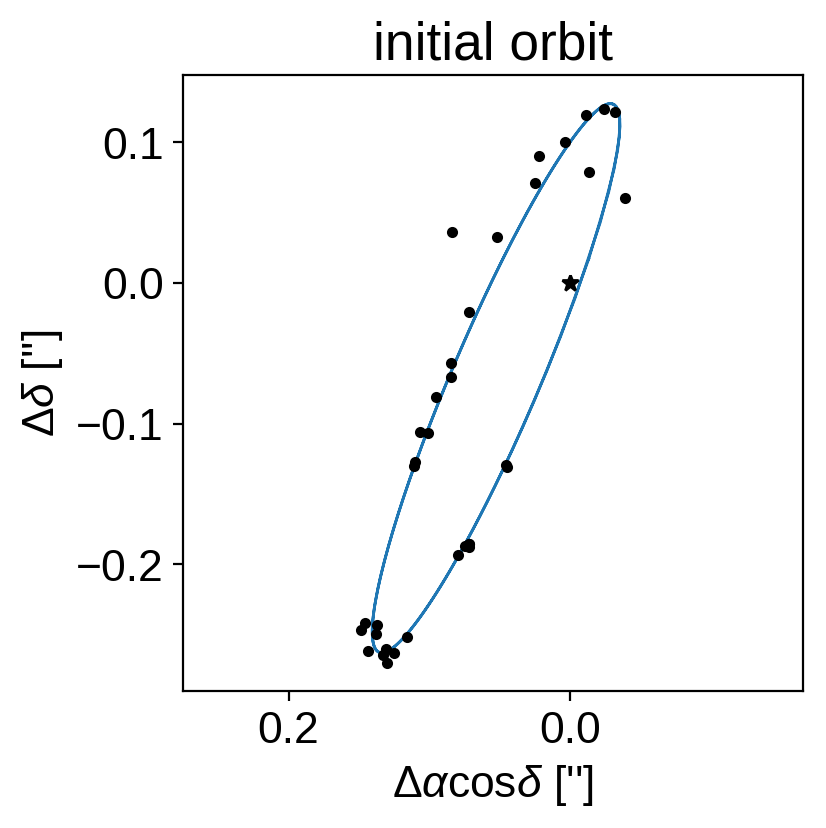

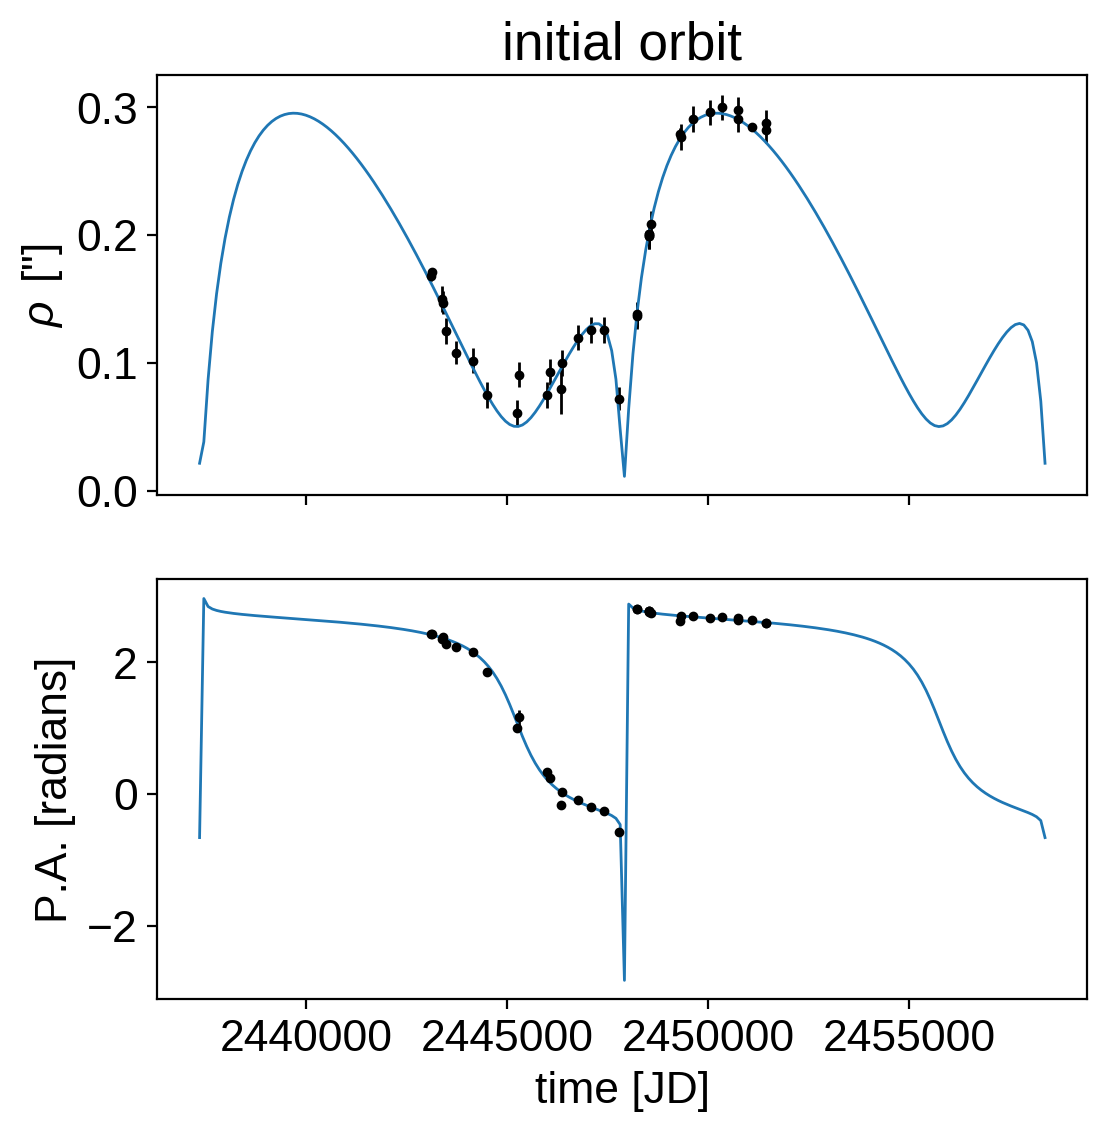

In [7]:
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e,
    omega=omega, Omega=Omega)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200) # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit 
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta) # X is north
ys = rho * np.sin(theta) # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit");

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit");

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [JD]");

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)

def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec 
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)("m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0])
            plx = pm.Deterministic("plx", 1e-3 * m_plx)
            
        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years, 
        # so we'll set a broad prior on logP
        logP = pm.Normal("logP", mu=np.log(25*yr), sd=10.0, testval=np.log(28.8*yr))
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = Omega + omega and m = Omega - omega instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=Omega0 + omega0)
        m = Angle("m", testval=Omega0 - omega0)
        omega = pm.Deterministic("omega", 0.5*(p - m))
        Omega = pm.Deterministic("Omega", 0.5*(p + m))

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2*np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun, t_periastron=tperi, period=P, 
            incl=incl, ecc=ecc, omega=omega, Omega=Omega)
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal("log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0)
        log_theta_s = pm.Normal("log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0)
        rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
        theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to 
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting 
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)
    
    return model, map_soln

model, map_soln = get_model()

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 104.85554109314326 -> 147.14399186006236


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 147.14399186006236 -> 167.64220598198335


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 167.64220598198335 -> 210.06340668298844


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 210.06340668298844 -> 210.50136991122025


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__']


message: Optimization terminated successfully.
logp: 210.50136991122025 -> 215.0211774221088


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

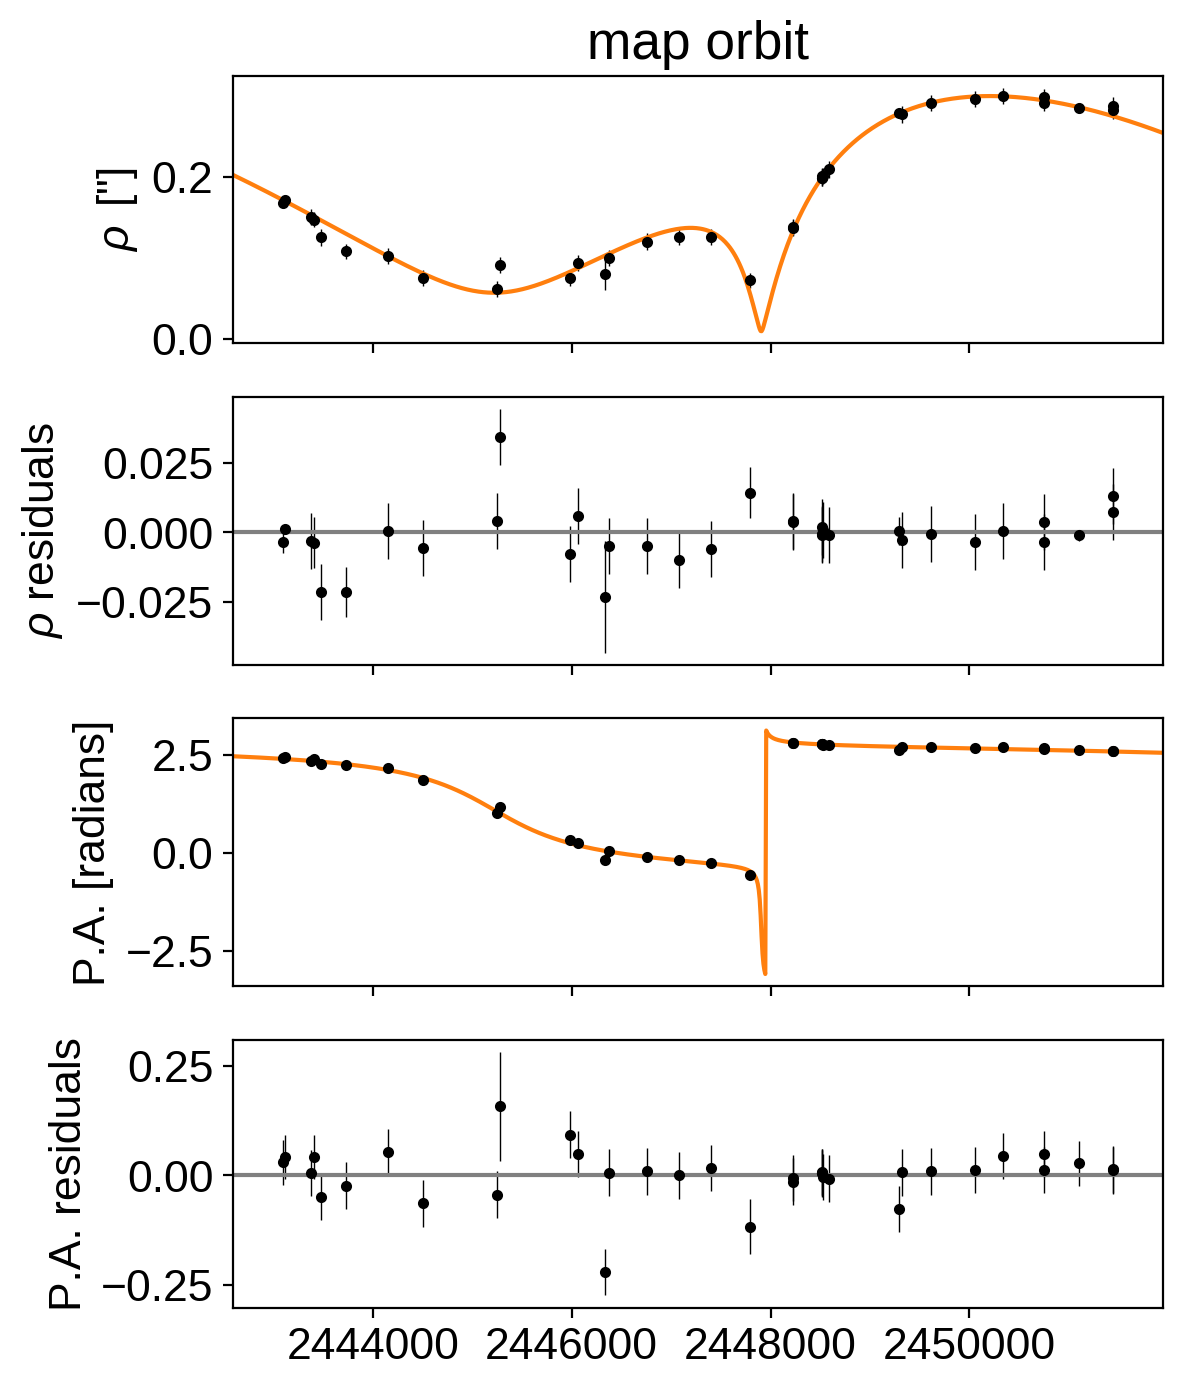

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw) 

ax[3].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("map orbit");

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<00:05, 134.46draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:08, 97.47draws/s] 

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:10, 72.56draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:12, 64.11draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:12, 62.69draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:00<00:12, 61.48draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:00<00:12, 58.94draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:00<00:13, 56.91draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:00<00:12, 60.29draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:12, 57.26draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:01<00:12, 56.41draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:01<00:12, 58.61draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:01<00:11, 62.06draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:01<00:11, 59.11draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:01<00:12, 58.10draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:01<00:12, 55.79draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:01<00:12, 55.82draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:02<00:12, 56.56draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:02<00:12, 56.01draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:02<00:11, 56.65draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:02<00:11, 57.16draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:02<00:10, 60.64draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:02<00:10, 63.96draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:02<00:09, 67.57draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:02<00:09, 68.25draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:02<00:09, 69.25draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:03<00:09, 65.26draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:03<00:09, 65.57draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:03<00:09, 62.09draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:03<00:09, 62.24draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:03<00:09, 60.99draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:03<00:09, 61.53draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:03<00:08, 63.85draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:03<00:08, 64.26draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:04<00:08, 64.46draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:04<00:08, 65.42draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:04<00:08, 62.88draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:04<00:07, 67.09draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:04<00:08, 64.66draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:04<00:07, 65.82draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:04<00:07, 66.31draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:04<00:07, 69.44draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:04<00:07, 64.73draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:05<00:08, 60.58draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:05<00:07, 60.91draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:05<00:07, 62.27draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:05<00:07, 58.90draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:05<00:07, 60.84draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:05<00:07, 58.98draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:05<00:07, 58.64draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:05<00:07, 61.37draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:05<00:06, 63.46draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:06<00:06, 63.61draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:06<00:06, 65.51draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:06<00:06, 62.57draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:06<00:06, 64.35draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:06<00:05, 69.23draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:06<00:05, 64.56draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:06<00:06, 62.93draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:06<00:05, 63.30draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [00:07<00:06, 59.92draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:07<00:05, 60.20draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:07<00:05, 61.58draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:07<00:05, 62.24draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:07<00:05, 62.88draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:07<00:05, 64.96draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:07<00:05, 60.53draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:07<00:05, 62.90draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:07<00:04, 63.36draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:08<00:05, 59.87draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:08<00:05, 58.59draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [00:08<00:04, 58.05draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:08<00:05, 54.54draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [00:08<00:04, 56.30draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:08<00:04, 57.36draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:08<00:04, 59.83draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:08<00:04, 57.06draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:09<00:04, 61.11draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:09<00:03, 61.58draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:09<00:03, 61.96draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:09<00:03, 60.75draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [00:09<00:03, 67.07draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:09<00:03, 68.97draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:09<00:02, 72.19draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:09<00:02, 65.19draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [00:09<00:02, 62.10draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:10<00:02, 63.55draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:10<00:02, 64.15draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:10<00:02, 60.24draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:10<00:02, 57.08draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:10<00:02, 56.47draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:10<00:02, 56.85draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:10<00:02, 56.44draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:10<00:02, 59.30draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:11<00:02, 55.33draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:11<00:02, 54.66draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:11<00:01, 59.51draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:11<00:01, 56.75draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [00:11<00:01, 52.86draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:11<00:01, 58.47draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:11<00:01, 55.90draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:11<00:01, 60.75draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:11<00:00, 65.45draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:12<00:00, 65.69draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:12<00:00, 65.00draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:12<00:00, 66.41draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:12<00:00, 64.09draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:12<00:00, 58.33draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:12<00:00, 54.99draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:12<00:00, 54.53draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:13<00:00, 46.84draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:13<00:00, 40.23draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:13<00:00, 58.94draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 13/408 [00:00<00:03, 118.24draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:03, 102.18draws/s]

Sampling 4 chains:   7%|▋         | 27/408 [00:00<00:05, 74.62draws/s] 

Sampling 4 chains:   9%|▊         | 35/408 [00:00<00:04, 75.91draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:00<00:04, 73.50draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:00<00:04, 80.91draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:00<00:04, 77.10draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:00<00:04, 79.36draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:00<00:04, 77.57draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:01<00:03, 82.95draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:01<00:03, 79.22draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:01<00:03, 80.08draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:01<00:03, 81.50draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:01<00:03, 79.28draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:01<00:03, 80.46draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:01<00:03, 81.87draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:01<00:03, 83.38draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:01<00:02, 85.15draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:02<00:02, 87.47draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:02<00:02, 92.60draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:02<00:02, 91.25draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:02<00:02, 95.11draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:02<00:02, 92.05draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:02<00:02, 87.63draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:02<00:02, 84.13draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:02<00:01, 86.08draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:03<00:01, 82.97draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:03<00:01, 90.41draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:03<00:01, 86.41draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:03<00:01, 77.11draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:03<00:01, 77.55draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [00:03<00:01, 80.78draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:03<00:01, 81.97draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:03<00:01, 81.81draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [00:03<00:00, 81.60draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:04<00:00, 84.42draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:04<00:00, 94.44draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:04<00:00, 90.72draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:04<00:00, 85.88draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:04<00:00, 75.08draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:04<00:00, 57.62draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:04<00:00, 55.54draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:05<00:00, 50.58draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:05<00:00, 77.20draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:02, 316.22draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:00<00:02, 314.99draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:00<00:01, 357.09draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:00<00:01, 376.04draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:00<00:01, 385.89draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:00<00:01, 427.20draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:00<00:01, 456.99draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:00<00:00, 494.55draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [00:00<00:00, 527.48draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [00:01<00:00, 526.48draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:01<00:00, 508.45draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:01<00:00, 511.02draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [00:01<00:00, 504.96draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:01<00:00, 537.71draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:01<00:00, 570.16draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:01<00:00, 491.83draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:00<00:03, 444.04draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:00<00:04, 336.45draws/s]

Sampling 4 chains:   6%|▌         | 92/1608 [00:00<00:04, 304.27draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:00<00:05, 293.21draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:00<00:04, 311.56draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:00<00:04, 349.41draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:00<00:03, 373.21draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:00<00:03, 385.02draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [00:00<00:03, 404.63draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [00:01<00:02, 436.45draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [00:01<00:02, 445.57draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [00:01<00:02, 439.07draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:01<00:02, 438.05draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:01<00:02, 447.05draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [00:01<00:02, 473.11draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [00:01<00:01, 483.47draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [00:01<00:01, 483.14draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [00:01<00:01, 493.90draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [00:01<00:01, 500.46draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [00:02<00:01, 490.95draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [00:02<00:01, 477.89draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [00:02<00:01, 476.70draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [00:02<00:01, 477.98draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [00:02<00:01, 471.58draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [00:02<00:01, 464.13draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [00:02<00:00, 494.67draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [00:02<00:00, 501.06draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [00:02<00:00, 503.52draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [00:02<00:00, 495.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [00:03<00:00, 488.29draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [00:03<00:00, 493.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [00:03<00:00, 425.79draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [00:03<00:00, 385.78draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [00:03<00:00, 297.06draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 417.14draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:00<00:08, 366.12draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:00<00:08, 387.15draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:00<00:08, 382.76draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:00<00:07, 381.51draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:00<00:07, 376.45draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:00<00:07, 380.19draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:00<00:08, 345.53draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [00:00<00:07, 384.02draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:00<00:07, 390.14draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [00:01<00:07, 394.27draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [00:01<00:06, 422.39draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [00:01<00:06, 434.22draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [00:01<00:05, 443.66draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [00:01<00:05, 448.28draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [00:01<00:05, 450.13draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [00:01<00:05, 475.62draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [00:01<00:04, 493.96draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [00:01<00:05, 479.93draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [00:01<00:04, 487.07draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [00:02<00:04, 483.08draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [00:02<00:04, 487.00draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [00:02<00:04, 525.24draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [00:02<00:04, 515.11draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [00:02<00:04, 513.52draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [00:02<00:03, 514.55draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [00:02<00:04, 484.60draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [00:02<00:03, 516.34draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [00:02<00:03, 527.73draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [00:03<00:03, 523.10draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [00:03<00:03, 499.33draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [00:03<00:03, 490.03draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [00:03<00:03, 526.52draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [00:03<00:03, 520.43draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [00:03<00:02, 528.32draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [00:03<00:02, 505.87draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [00:03<00:02, 478.95draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [00:03<00:02, 457.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [00:04<00:02, 466.76draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [00:04<00:02, 468.46draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [00:04<00:02, 496.68draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [00:04<00:02, 489.03draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [00:04<00:02, 514.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [00:04<00:01, 531.08draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [00:04<00:01, 529.93draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [00:04<00:01, 517.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [00:04<00:01, 538.88draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [00:04<00:01, 556.14draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [00:05<00:01, 518.03draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [00:05<00:01, 524.30draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [00:05<00:01, 500.78draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [00:05<00:01, 521.97draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [00:05<00:00, 553.36draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [00:05<00:00, 531.25draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [00:05<00:00, 508.66draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [00:05<00:00, 508.87draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [00:05<00:00, 496.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [00:06<00:00, 510.70draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [00:06<00:00, 501.99draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [00:06<00:00, 487.69draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [00:06<00:00, 455.85draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [00:06<00:00, 411.85draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [00:06<00:00, 347.03draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:06<00:00, 471.13draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 28/9208 [00:00<00:33, 270.86draws/s]

Sampling 4 chains:   1%|          | 53/9208 [00:00<00:34, 263.52draws/s]

Sampling 4 chains:   1%|          | 73/9208 [00:00<00:38, 236.03draws/s]

Sampling 4 chains:   1%|          | 103/9208 [00:00<00:36, 250.47draws/s]

Sampling 4 chains:   2%|▏         | 154/9208 [00:00<00:30, 295.38draws/s]

Sampling 4 chains:   2%|▏         | 200/9208 [00:00<00:27, 330.47draws/s]

Sampling 4 chains:   3%|▎         | 235/9208 [00:00<00:26, 335.95draws/s]

Sampling 4 chains:   3%|▎         | 272/9208 [00:00<00:26, 343.34draws/s]

Sampling 4 chains:   3%|▎         | 307/9208 [00:00<00:26, 341.73draws/s]

Sampling 4 chains:   4%|▍         | 359/9208 [00:01<00:23, 378.84draws/s]

Sampling 4 chains:   4%|▍         | 408/9208 [00:01<00:21, 402.33draws/s]

Sampling 4 chains:   5%|▍         | 450/9208 [00:01<00:23, 375.03draws/s]

Sampling 4 chains:   5%|▌         | 495/9208 [00:01<00:22, 392.98draws/s]

Sampling 4 chains:   6%|▌         | 556/9208 [00:01<00:19, 438.99draws/s]

Sampling 4 chains:   7%|▋         | 605/9208 [00:01<00:18, 453.04draws/s]

Sampling 4 chains:   7%|▋         | 654/9208 [00:01<00:18, 462.44draws/s]

Sampling 4 chains:   8%|▊         | 717/9208 [00:01<00:16, 499.63draws/s]

Sampling 4 chains:   8%|▊         | 769/9208 [00:01<00:16, 504.27draws/s]

Sampling 4 chains:   9%|▉         | 821/9208 [00:01<00:18, 461.97draws/s]

Sampling 4 chains:   9%|▉         | 869/9208 [00:02<00:19, 422.42draws/s]

Sampling 4 chains:  10%|▉         | 914/9208 [00:02<00:19, 415.57draws/s]

Sampling 4 chains:  10%|█         | 957/9208 [00:02<00:20, 404.66draws/s]

Sampling 4 chains:  11%|█         | 1000/9208 [00:02<00:19, 411.81draws/s]

Sampling 4 chains:  11%|█▏        | 1048/9208 [00:02<00:19, 429.31draws/s]

Sampling 4 chains:  12%|█▏        | 1104/9208 [00:02<00:17, 460.31draws/s]

Sampling 4 chains:  13%|█▎        | 1158/9208 [00:02<00:16, 475.28draws/s]

Sampling 4 chains:  13%|█▎        | 1207/9208 [00:02<00:16, 476.35draws/s]

Sampling 4 chains:  14%|█▎        | 1265/9208 [00:02<00:15, 502.65draws/s]

Sampling 4 chains:  14%|█▍        | 1317/9208 [00:03<00:15, 505.35draws/s]

Sampling 4 chains:  15%|█▍        | 1369/9208 [00:03<00:16, 488.88draws/s]

Sampling 4 chains:  15%|█▌        | 1419/9208 [00:03<00:16, 477.84draws/s]

Sampling 4 chains:  16%|█▌        | 1468/9208 [00:03<00:16, 469.57draws/s]

Sampling 4 chains:  17%|█▋        | 1521/9208 [00:03<00:15, 484.85draws/s]

Sampling 4 chains:  17%|█▋        | 1574/9208 [00:03<00:15, 491.38draws/s]

Sampling 4 chains:  18%|█▊        | 1624/9208 [00:03<00:16, 469.23draws/s]

Sampling 4 chains:  18%|█▊        | 1678/9208 [00:03<00:15, 488.36draws/s]

Sampling 4 chains:  19%|█▉        | 1741/9208 [00:03<00:14, 522.22draws/s]

Sampling 4 chains:  19%|█▉        | 1795/9208 [00:04<00:14, 495.62draws/s]

Sampling 4 chains:  20%|██        | 1851/9208 [00:04<00:14, 509.61draws/s]

Sampling 4 chains:  21%|██        | 1905/9208 [00:04<00:14, 518.04draws/s]

Sampling 4 chains:  21%|██▏       | 1958/9208 [00:04<00:13, 521.50draws/s]

Sampling 4 chains:  22%|██▏       | 2011/9208 [00:04<00:14, 508.22draws/s]

Sampling 4 chains:  22%|██▏       | 2063/9208 [00:04<00:14, 505.54draws/s]

Sampling 4 chains:  23%|██▎       | 2117/9208 [00:04<00:13, 515.21draws/s]

Sampling 4 chains:  24%|██▎       | 2169/9208 [00:04<00:14, 491.15draws/s]

Sampling 4 chains:  24%|██▍       | 2219/9208 [00:04<00:15, 465.39draws/s]

Sampling 4 chains:  25%|██▍       | 2270/9208 [00:05<00:14, 476.49draws/s]

Sampling 4 chains:  25%|██▌       | 2319/9208 [00:05<00:14, 473.10draws/s]

Sampling 4 chains:  26%|██▌       | 2376/9208 [00:05<00:13, 497.89draws/s]

Sampling 4 chains:  26%|██▋       | 2427/9208 [00:05<00:13, 487.38draws/s]

Sampling 4 chains:  27%|██▋       | 2482/9208 [00:05<00:13, 503.34draws/s]

Sampling 4 chains:  28%|██▊       | 2533/9208 [00:05<00:13, 496.38draws/s]

Sampling 4 chains:  28%|██▊       | 2590/9208 [00:05<00:12, 513.22draws/s]

Sampling 4 chains:  29%|██▊       | 2647/9208 [00:05<00:12, 528.68draws/s]

Sampling 4 chains:  29%|██▉       | 2701/9208 [00:05<00:12, 529.78draws/s]

Sampling 4 chains:  30%|██▉       | 2757/9208 [00:05<00:12, 535.90draws/s]

Sampling 4 chains:  31%|███       | 2811/9208 [00:06<00:12, 514.98draws/s]

Sampling 4 chains:  31%|███       | 2863/9208 [00:06<00:12, 499.20draws/s]

Sampling 4 chains:  32%|███▏      | 2916/9208 [00:06<00:12, 505.48draws/s]

Sampling 4 chains:  32%|███▏      | 2971/9208 [00:06<00:12, 517.58draws/s]

Sampling 4 chains:  33%|███▎      | 3026/9208 [00:06<00:11, 522.73draws/s]

Sampling 4 chains:  33%|███▎      | 3082/9208 [00:06<00:11, 533.33draws/s]

Sampling 4 chains:  34%|███▍      | 3140/9208 [00:06<00:11, 544.75draws/s]

Sampling 4 chains:  35%|███▍      | 3195/9208 [00:06<00:11, 540.17draws/s]

Sampling 4 chains:  35%|███▌      | 3250/9208 [00:06<00:11, 512.74draws/s]

Sampling 4 chains:  36%|███▌      | 3302/9208 [00:07<00:11, 494.68draws/s]

Sampling 4 chains:  36%|███▋      | 3352/9208 [00:07<00:12, 478.43draws/s]

Sampling 4 chains:  37%|███▋      | 3402/9208 [00:07<00:11, 484.60draws/s]

Sampling 4 chains:  38%|███▊      | 3458/9208 [00:07<00:11, 502.41draws/s]

Sampling 4 chains:  38%|███▊      | 3511/9208 [00:07<00:11, 509.92draws/s]

Sampling 4 chains:  39%|███▊      | 3563/9208 [00:07<00:11, 474.25draws/s]

Sampling 4 chains:  39%|███▉      | 3616/9208 [00:07<00:11, 489.25draws/s]

Sampling 4 chains:  40%|███▉      | 3666/9208 [00:07<00:11, 471.04draws/s]

Sampling 4 chains:  40%|████      | 3714/9208 [00:07<00:12, 454.19draws/s]

Sampling 4 chains:  41%|████      | 3767/9208 [00:07<00:11, 472.99draws/s]

Sampling 4 chains:  41%|████▏     | 3820/9208 [00:08<00:11, 486.50draws/s]

Sampling 4 chains:  42%|████▏     | 3879/9208 [00:08<00:10, 510.94draws/s]

Sampling 4 chains:  43%|████▎     | 3931/9208 [00:08<00:10, 504.82draws/s]

Sampling 4 chains:  43%|████▎     | 3986/9208 [00:08<00:10, 516.29draws/s]

Sampling 4 chains:  44%|████▍     | 4044/9208 [00:08<00:09, 532.13draws/s]

Sampling 4 chains:  45%|████▍     | 4099/9208 [00:08<00:09, 536.64draws/s]

Sampling 4 chains:  45%|████▌     | 4153/9208 [00:08<00:09, 535.08draws/s]

Sampling 4 chains:  46%|████▌     | 4212/9208 [00:08<00:09, 548.12draws/s]

Sampling 4 chains:  46%|████▋     | 4268/9208 [00:08<00:09, 533.83draws/s]

Sampling 4 chains:  47%|████▋     | 4322/9208 [00:09<00:09, 515.76draws/s]

Sampling 4 chains:  48%|████▊     | 4374/9208 [00:09<00:09, 504.81draws/s]

Sampling 4 chains:  48%|████▊     | 4426/9208 [00:09<00:09, 508.13draws/s]

Sampling 4 chains:  49%|████▊     | 4478/9208 [00:09<00:09, 511.44draws/s]

Sampling 4 chains:  49%|████▉     | 4530/9208 [00:09<00:09, 512.60draws/s]

Sampling 4 chains:  50%|████▉     | 4582/9208 [00:09<00:09, 494.16draws/s]

Sampling 4 chains:  50%|█████     | 4639/9208 [00:09<00:08, 514.56draws/s]

Sampling 4 chains:  51%|█████     | 4694/9208 [00:09<00:08, 522.56draws/s]

Sampling 4 chains:  52%|█████▏    | 4749/9208 [00:09<00:08, 530.13draws/s]

Sampling 4 chains:  52%|█████▏    | 4808/9208 [00:09<00:08, 544.81draws/s]

Sampling 4 chains:  53%|█████▎    | 4863/9208 [00:10<00:08, 530.40draws/s]

Sampling 4 chains:  53%|█████▎    | 4917/9208 [00:10<00:08, 495.97draws/s]

Sampling 4 chains:  54%|█████▍    | 4968/9208 [00:10<00:08, 487.35draws/s]

Sampling 4 chains:  54%|█████▍    | 5018/9208 [00:10<00:08, 473.51draws/s]

Sampling 4 chains:  55%|█████▌    | 5066/9208 [00:10<00:08, 472.05draws/s]

Sampling 4 chains:  56%|█████▌    | 5115/9208 [00:10<00:08, 475.93draws/s]

Sampling 4 chains:  56%|█████▌    | 5168/9208 [00:10<00:08, 485.78draws/s]

Sampling 4 chains:  57%|█████▋    | 5217/9208 [00:10<00:08, 486.28draws/s]

Sampling 4 chains:  57%|█████▋    | 5279/9208 [00:10<00:07, 519.91draws/s]

Sampling 4 chains:  58%|█████▊    | 5343/9208 [00:11<00:07, 547.87draws/s]

Sampling 4 chains:  59%|█████▊    | 5399/9208 [00:11<00:07, 539.22draws/s]

Sampling 4 chains:  59%|█████▉    | 5454/9208 [00:11<00:07, 519.27draws/s]

Sampling 4 chains:  60%|█████▉    | 5507/9208 [00:11<00:07, 520.80draws/s]

Sampling 4 chains:  60%|██████    | 5560/9208 [00:11<00:07, 506.15draws/s]

Sampling 4 chains:  61%|██████    | 5612/9208 [00:11<00:07, 502.24draws/s]

Sampling 4 chains:  62%|██████▏   | 5667/9208 [00:11<00:06, 515.30draws/s]

Sampling 4 chains:  62%|██████▏   | 5727/9208 [00:11<00:06, 537.70draws/s]

Sampling 4 chains:  63%|██████▎   | 5794/9208 [00:11<00:06, 568.87draws/s]

Sampling 4 chains:  64%|██████▎   | 5859/9208 [00:11<00:05, 588.95draws/s]

Sampling 4 chains:  64%|██████▍   | 5923/9208 [00:12<00:05, 601.19draws/s]

Sampling 4 chains:  65%|██████▍   | 5984/9208 [00:12<00:05, 600.92draws/s]

Sampling 4 chains:  66%|██████▌   | 6045/9208 [00:12<00:05, 593.17draws/s]

Sampling 4 chains:  66%|██████▋   | 6105/9208 [00:12<00:05, 575.61draws/s]

Sampling 4 chains:  67%|██████▋   | 6163/9208 [00:12<00:05, 562.58draws/s]

Sampling 4 chains:  68%|██████▊   | 6220/9208 [00:12<00:05, 529.63draws/s]

Sampling 4 chains:  68%|██████▊   | 6274/9208 [00:12<00:05, 517.53draws/s]

Sampling 4 chains:  69%|██████▊   | 6327/9208 [00:12<00:05, 494.23draws/s]

Sampling 4 chains:  69%|██████▉   | 6377/9208 [00:12<00:05, 492.21draws/s]

Sampling 4 chains:  70%|██████▉   | 6427/9208 [00:13<00:05, 474.91draws/s]

Sampling 4 chains:  70%|███████   | 6483/9208 [00:13<00:05, 495.07draws/s]

Sampling 4 chains:  71%|███████   | 6534/9208 [00:13<00:05, 486.46draws/s]

Sampling 4 chains:  72%|███████▏  | 6598/9208 [00:13<00:04, 522.31draws/s]

Sampling 4 chains:  72%|███████▏  | 6666/9208 [00:13<00:04, 559.98draws/s]

Sampling 4 chains:  73%|███████▎  | 6735/9208 [00:13<00:04, 593.05draws/s]

Sampling 4 chains:  74%|███████▍  | 6796/9208 [00:13<00:04, 597.87draws/s]

Sampling 4 chains:  74%|███████▍  | 6857/9208 [00:13<00:04, 567.07draws/s]

Sampling 4 chains:  75%|███████▌  | 6917/9208 [00:13<00:03, 574.59draws/s]

Sampling 4 chains:  76%|███████▌  | 6976/9208 [00:13<00:03, 568.34draws/s]

Sampling 4 chains:  76%|███████▋  | 7034/9208 [00:14<00:04, 522.68draws/s]

Sampling 4 chains:  77%|███████▋  | 7088/9208 [00:14<00:04, 494.89draws/s]

Sampling 4 chains:  78%|███████▊  | 7141/9208 [00:14<00:04, 504.36draws/s]

Sampling 4 chains:  78%|███████▊  | 7193/9208 [00:14<00:03, 505.15draws/s]

Sampling 4 chains:  79%|███████▊  | 7247/9208 [00:14<00:03, 515.09draws/s]

Sampling 4 chains:  79%|███████▉  | 7299/9208 [00:14<00:03, 514.45draws/s]

Sampling 4 chains:  80%|███████▉  | 7351/9208 [00:14<00:03, 513.56draws/s]

Sampling 4 chains:  80%|████████  | 7403/9208 [00:14<00:03, 498.16draws/s]

Sampling 4 chains:  81%|████████  | 7454/9208 [00:14<00:03, 481.21draws/s]

Sampling 4 chains:  81%|████████▏ | 7503/9208 [00:15<00:03, 459.23draws/s]

Sampling 4 chains:  82%|████████▏ | 7550/9208 [00:15<00:03, 459.28draws/s]

Sampling 4 chains:  83%|████████▎ | 7605/9208 [00:15<00:03, 482.52draws/s]

Sampling 4 chains:  83%|████████▎ | 7654/9208 [00:15<00:03, 482.85draws/s]

Sampling 4 chains:  84%|████████▎ | 7705/9208 [00:15<00:03, 487.20draws/s]

Sampling 4 chains:  84%|████████▍ | 7756/9208 [00:15<00:02, 491.77draws/s]

Sampling 4 chains:  85%|████████▍ | 7811/9208 [00:15<00:02, 506.07draws/s]

Sampling 4 chains:  85%|████████▌ | 7862/9208 [00:15<00:02, 480.71draws/s]

Sampling 4 chains:  86%|████████▌ | 7911/9208 [00:15<00:02, 467.95draws/s]

Sampling 4 chains:  86%|████████▋ | 7959/9208 [00:16<00:02, 469.57draws/s]

Sampling 4 chains:  87%|████████▋ | 8007/9208 [00:16<00:02, 469.67draws/s]

Sampling 4 chains:  88%|████████▊ | 8062/9208 [00:16<00:02, 490.79draws/s]

Sampling 4 chains:  88%|████████▊ | 8128/9208 [00:16<00:02, 531.63draws/s]

Sampling 4 chains:  89%|████████▉ | 8183/9208 [00:16<00:01, 526.31draws/s]

Sampling 4 chains:  89%|████████▉ | 8237/9208 [00:16<00:01, 521.28draws/s]

Sampling 4 chains:  90%|█████████ | 8292/9208 [00:16<00:01, 526.46draws/s]

Sampling 4 chains:  91%|█████████ | 8346/9208 [00:16<00:01, 501.17draws/s]

Sampling 4 chains:  91%|█████████ | 8397/9208 [00:16<00:01, 498.08draws/s]

Sampling 4 chains:  92%|█████████▏| 8448/9208 [00:16<00:01, 490.26draws/s]

Sampling 4 chains:  92%|█████████▏| 8505/9208 [00:17<00:01, 511.09draws/s]

Sampling 4 chains:  93%|█████████▎| 8557/9208 [00:17<00:01, 505.88draws/s]

Sampling 4 chains:  93%|█████████▎| 8608/9208 [00:17<00:01, 495.57draws/s]

Sampling 4 chains:  94%|█████████▍| 8659/9208 [00:17<00:01, 499.10draws/s]

Sampling 4 chains:  95%|█████████▍| 8716/9208 [00:17<00:00, 517.04draws/s]

Sampling 4 chains:  95%|█████████▌| 8775/9208 [00:17<00:00, 535.52draws/s]

Sampling 4 chains:  96%|█████████▌| 8829/9208 [00:17<00:00, 536.06draws/s]

Sampling 4 chains:  96%|█████████▋| 8883/9208 [00:17<00:00, 530.55draws/s]

Sampling 4 chains:  97%|█████████▋| 8943/9208 [00:17<00:00, 549.01draws/s]

Sampling 4 chains:  98%|█████████▊| 9008/9208 [00:18<00:00, 575.28draws/s]

Sampling 4 chains:  98%|█████████▊| 9068/9208 [00:18<00:00, 581.89draws/s]

Sampling 4 chains:  99%|█████████▉| 9127/9208 [00:18<00:00, 545.17draws/s]

Sampling 4 chains: 100%|█████████▉| 9183/9208 [00:18<00:00, 290.26draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:18<00:00, 487.87draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 40/1208 [00:00<00:02, 392.61draws/s]

Sampling 4 chains:   7%|▋         | 87/1208 [00:00<00:02, 412.14draws/s]

Sampling 4 chains:  10%|▉         | 117/1208 [00:00<00:02, 365.22draws/s]

Sampling 4 chains:  13%|█▎        | 158/1208 [00:00<00:02, 377.45draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [00:00<00:02, 389.97draws/s]

Sampling 4 chains:  21%|██        | 249/1208 [00:00<00:02, 412.92draws/s]

Sampling 4 chains:  25%|██▌       | 304/1208 [00:00<00:02, 441.77draws/s]

Sampling 4 chains:  29%|██▉       | 353/1208 [00:00<00:01, 452.62draws/s]

Sampling 4 chains:  34%|███▎      | 406/1208 [00:00<00:01, 469.06draws/s]

Sampling 4 chains:  38%|███▊      | 453/1208 [00:01<00:01, 448.31draws/s]

Sampling 4 chains:  41%|████      | 498/1208 [00:01<00:01, 431.81draws/s]

Sampling 4 chains:  45%|████▍     | 542/1208 [00:01<00:01, 431.38draws/s]

Sampling 4 chains:  49%|████▊     | 586/1208 [00:01<00:01, 410.96draws/s]

Sampling 4 chains:  52%|█████▏    | 633/1208 [00:01<00:01, 426.04draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [00:01<00:01, 453.17draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [00:01<00:01, 443.15draws/s]

Sampling 4 chains:  65%|██████▍   | 783/1208 [00:01<00:00, 455.75draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [00:01<00:00, 487.59draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [00:01<00:00, 488.24draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [00:02<00:00, 504.94draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [00:02<00:00, 506.62draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [00:02<00:00, 526.50draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [00:02<00:00, 502.85draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [00:02<00:00, 390.14draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [00:02<00:00, 231.26draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:03<00:00, 400.75draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 54/16000 [00:00<00:29, 535.86draws/s]

Sampling 4 chains:   1%|          | 127/16000 [00:00<00:27, 580.65draws/s]

Sampling 4 chains:   1%|          | 199/16000 [00:00<00:25, 615.12draws/s]

Sampling 4 chains:   2%|▏         | 270/16000 [00:00<00:24, 639.68draws/s]

Sampling 4 chains:   2%|▏         | 349/16000 [00:00<00:23, 678.40draws/s]

Sampling 4 chains:   3%|▎         | 425/16000 [00:00<00:22, 700.88draws/s]

Sampling 4 chains:   3%|▎         | 498/16000 [00:00<00:21, 707.59draws/s]

Sampling 4 chains:   4%|▎         | 575/16000 [00:00<00:21, 723.04draws/s]

Sampling 4 chains:   4%|▍         | 651/16000 [00:00<00:20, 733.68draws/s]

Sampling 4 chains:   5%|▍         | 725/16000 [00:01<00:20, 734.51draws/s]

Sampling 4 chains:   5%|▍         | 798/16000 [00:01<00:20, 730.12draws/s]

Sampling 4 chains:   5%|▌         | 871/16000 [00:01<00:21, 716.32draws/s]

Sampling 4 chains:   6%|▌         | 948/16000 [00:01<00:20, 731.41draws/s]

Sampling 4 chains:   6%|▋         | 1023/16000 [00:01<00:20, 735.41draws/s]

Sampling 4 chains:   7%|▋         | 1097/16000 [00:01<00:20, 728.59draws/s]

Sampling 4 chains:   7%|▋         | 1172/16000 [00:01<00:20, 733.40draws/s]

Sampling 4 chains:   8%|▊         | 1251/16000 [00:01<00:19, 748.49draws/s]

Sampling 4 chains:   8%|▊         | 1326/16000 [00:01<00:19, 740.09draws/s]

Sampling 4 chains:   9%|▉         | 1401/16000 [00:01<00:19, 742.27draws/s]

Sampling 4 chains:   9%|▉         | 1480/16000 [00:02<00:19, 753.05draws/s]

Sampling 4 chains:  10%|▉         | 1556/16000 [00:02<00:19, 745.37draws/s]

Sampling 4 chains:  10%|█         | 1632/16000 [00:02<00:19, 748.09draws/s]

Sampling 4 chains:  11%|█         | 1708/16000 [00:02<00:19, 749.91draws/s]

Sampling 4 chains:  11%|█         | 1785/16000 [00:02<00:18, 754.95draws/s]

Sampling 4 chains:  12%|█▏        | 1861/16000 [00:02<00:18, 750.30draws/s]

Sampling 4 chains:  12%|█▏        | 1937/16000 [00:02<00:19, 727.74draws/s]

Sampling 4 chains:  13%|█▎        | 2010/16000 [00:02<00:19, 720.37draws/s]

Sampling 4 chains:  13%|█▎        | 2088/16000 [00:02<00:18, 737.25draws/s]

Sampling 4 chains:  14%|█▎        | 2164/16000 [00:02<00:18, 742.83draws/s]

Sampling 4 chains:  14%|█▍        | 2239/16000 [00:03<00:19, 722.82draws/s]

Sampling 4 chains:  14%|█▍        | 2312/16000 [00:03<00:19, 720.26draws/s]

Sampling 4 chains:  15%|█▍        | 2385/16000 [00:03<00:18, 722.01draws/s]

Sampling 4 chains:  15%|█▌        | 2459/16000 [00:03<00:18, 726.10draws/s]

Sampling 4 chains:  16%|█▌        | 2535/16000 [00:03<00:18, 735.91draws/s]

Sampling 4 chains:  16%|█▋        | 2611/16000 [00:03<00:18, 740.83draws/s]

Sampling 4 chains:  17%|█▋        | 2686/16000 [00:03<00:18, 739.54draws/s]

Sampling 4 chains:  17%|█▋        | 2761/16000 [00:03<00:17, 739.80draws/s]

Sampling 4 chains:  18%|█▊        | 2836/16000 [00:03<00:17, 732.98draws/s]

Sampling 4 chains:  18%|█▊        | 2912/16000 [00:03<00:17, 740.58draws/s]

Sampling 4 chains:  19%|█▊        | 2987/16000 [00:04<00:17, 742.07draws/s]

Sampling 4 chains:  19%|█▉        | 3062/16000 [00:04<00:18, 716.44draws/s]

Sampling 4 chains:  20%|█▉        | 3140/16000 [00:04<00:17, 729.68draws/s]

Sampling 4 chains:  20%|██        | 3218/16000 [00:04<00:17, 743.01draws/s]

Sampling 4 chains:  21%|██        | 3293/16000 [00:04<00:17, 737.44draws/s]

Sampling 4 chains:  21%|██        | 3367/16000 [00:04<00:17, 731.19draws/s]

Sampling 4 chains:  22%|██▏       | 3441/16000 [00:04<00:17, 715.39draws/s]

Sampling 4 chains:  22%|██▏       | 3517/16000 [00:04<00:17, 726.82draws/s]

Sampling 4 chains:  22%|██▏       | 3590/16000 [00:04<00:17, 709.43draws/s]

Sampling 4 chains:  23%|██▎       | 3665/16000 [00:05<00:17, 720.19draws/s]

Sampling 4 chains:  23%|██▎       | 3743/16000 [00:05<00:16, 734.94draws/s]

Sampling 4 chains:  24%|██▍       | 3817/16000 [00:05<00:16, 721.25draws/s]

Sampling 4 chains:  24%|██▍       | 3890/16000 [00:05<00:16, 717.44draws/s]

Sampling 4 chains:  25%|██▍       | 3964/16000 [00:05<00:16, 720.84draws/s]

Sampling 4 chains:  25%|██▌       | 4038/16000 [00:05<00:16, 716.61draws/s]

Sampling 4 chains:  26%|██▌       | 4110/16000 [00:05<00:16, 707.93draws/s]

Sampling 4 chains:  26%|██▌       | 4182/16000 [00:05<00:16, 709.74draws/s]

Sampling 4 chains:  27%|██▋       | 4257/16000 [00:05<00:16, 718.16draws/s]

Sampling 4 chains:  27%|██▋       | 4330/16000 [00:05<00:16, 719.39draws/s]

Sampling 4 chains:  28%|██▊       | 4402/16000 [00:06<00:16, 706.30draws/s]

Sampling 4 chains:  28%|██▊       | 4474/16000 [00:06<00:16, 707.59draws/s]

Sampling 4 chains:  28%|██▊       | 4553/16000 [00:06<00:15, 728.95draws/s]

Sampling 4 chains:  29%|██▉       | 4627/16000 [00:06<00:15, 731.16draws/s]

Sampling 4 chains:  29%|██▉       | 4705/16000 [00:06<00:15, 743.21draws/s]

Sampling 4 chains:  30%|██▉       | 4780/16000 [00:06<00:15, 706.46draws/s]

Sampling 4 chains:  30%|███       | 4854/16000 [00:06<00:15, 714.68draws/s]

Sampling 4 chains:  31%|███       | 4926/16000 [00:06<00:15, 709.74draws/s]

Sampling 4 chains:  31%|███▏      | 5002/16000 [00:06<00:15, 723.45draws/s]

Sampling 4 chains:  32%|███▏      | 5077/16000 [00:06<00:14, 729.08draws/s]

Sampling 4 chains:  32%|███▏      | 5152/16000 [00:07<00:14, 733.13draws/s]

Sampling 4 chains:  33%|███▎      | 5226/16000 [00:07<00:14, 730.76draws/s]

Sampling 4 chains:  33%|███▎      | 5300/16000 [00:07<00:14, 718.54draws/s]

Sampling 4 chains:  34%|███▎      | 5374/16000 [00:07<00:14, 721.55draws/s]

Sampling 4 chains:  34%|███▍      | 5447/16000 [00:07<00:15, 701.54draws/s]

Sampling 4 chains:  35%|███▍      | 5521/16000 [00:07<00:14, 710.94draws/s]

Sampling 4 chains:  35%|███▍      | 5593/16000 [00:07<00:14, 697.65draws/s]

Sampling 4 chains:  35%|███▌      | 5671/16000 [00:07<00:14, 718.26draws/s]

Sampling 4 chains:  36%|███▌      | 5744/16000 [00:07<00:14, 713.77draws/s]

Sampling 4 chains:  36%|███▋      | 5817/16000 [00:08<00:14, 717.20draws/s]

Sampling 4 chains:  37%|███▋      | 5893/16000 [00:08<00:13, 727.79draws/s]

Sampling 4 chains:  37%|███▋      | 5966/16000 [00:08<00:13, 720.77draws/s]

Sampling 4 chains:  38%|███▊      | 6039/16000 [00:08<00:13, 714.59draws/s]

Sampling 4 chains:  38%|███▊      | 6111/16000 [00:08<00:14, 705.67draws/s]

Sampling 4 chains:  39%|███▊      | 6189/16000 [00:08<00:13, 724.92draws/s]

Sampling 4 chains:  39%|███▉      | 6264/16000 [00:08<00:13, 730.78draws/s]

Sampling 4 chains:  40%|███▉      | 6344/16000 [00:08<00:12, 748.74draws/s]

Sampling 4 chains:  40%|████      | 6420/16000 [00:08<00:13, 734.05draws/s]

Sampling 4 chains:  41%|████      | 6499/16000 [00:08<00:12, 749.70draws/s]

Sampling 4 chains:  41%|████      | 6575/16000 [00:09<00:12, 732.38draws/s]

Sampling 4 chains:  42%|████▏     | 6650/16000 [00:09<00:12, 735.82draws/s]

Sampling 4 chains:  42%|████▏     | 6724/16000 [00:09<00:12, 736.81draws/s]

Sampling 4 chains:  42%|████▏     | 6798/16000 [00:09<00:12, 724.78draws/s]

Sampling 4 chains:  43%|████▎     | 6874/16000 [00:09<00:12, 733.22draws/s]

Sampling 4 chains:  43%|████▎     | 6950/16000 [00:09<00:12, 739.44draws/s]

Sampling 4 chains:  44%|████▍     | 7025/16000 [00:09<00:12, 725.03draws/s]

Sampling 4 chains:  44%|████▍     | 7102/16000 [00:09<00:12, 735.39draws/s]

Sampling 4 chains:  45%|████▍     | 7178/16000 [00:09<00:11, 741.13draws/s]

Sampling 4 chains:  45%|████▌     | 7254/16000 [00:09<00:11, 746.36draws/s]

Sampling 4 chains:  46%|████▌     | 7329/16000 [00:10<00:11, 733.97draws/s]

Sampling 4 chains:  46%|████▋     | 7403/16000 [00:10<00:11, 730.68draws/s]

Sampling 4 chains:  47%|████▋     | 7477/16000 [00:10<00:11, 723.03draws/s]

Sampling 4 chains:  47%|████▋     | 7550/16000 [00:10<00:11, 706.78draws/s]

Sampling 4 chains:  48%|████▊     | 7624/16000 [00:10<00:11, 715.60draws/s]

Sampling 4 chains:  48%|████▊     | 7696/16000 [00:10<00:11, 716.18draws/s]

Sampling 4 chains:  49%|████▊     | 7770/16000 [00:10<00:11, 719.32draws/s]

Sampling 4 chains:  49%|████▉     | 7849/16000 [00:10<00:11, 738.48draws/s]

Sampling 4 chains:  50%|████▉     | 7926/16000 [00:10<00:10, 743.26draws/s]

Sampling 4 chains:  50%|█████     | 8001/16000 [00:10<00:10, 733.70draws/s]

Sampling 4 chains:  50%|█████     | 8075/16000 [00:11<00:10, 732.89draws/s]

Sampling 4 chains:  51%|█████     | 8149/16000 [00:11<00:11, 707.23draws/s]

Sampling 4 chains:  51%|█████▏    | 8225/16000 [00:11<00:10, 721.05draws/s]

Sampling 4 chains:  52%|█████▏    | 8302/16000 [00:11<00:10, 734.02draws/s]

Sampling 4 chains:  52%|█████▏    | 8376/16000 [00:11<00:10, 723.80draws/s]

Sampling 4 chains:  53%|█████▎    | 8449/16000 [00:11<00:10, 714.52draws/s]

Sampling 4 chains:  53%|█████▎    | 8524/16000 [00:11<00:10, 721.87draws/s]

Sampling 4 chains:  54%|█████▎    | 8599/16000 [00:11<00:10, 725.13draws/s]

Sampling 4 chains:  54%|█████▍    | 8676/16000 [00:11<00:09, 736.33draws/s]

Sampling 4 chains:  55%|█████▍    | 8750/16000 [00:12<00:09, 737.14draws/s]

Sampling 4 chains:  55%|█████▌    | 8827/16000 [00:12<00:09, 746.62draws/s]

Sampling 4 chains:  56%|█████▌    | 8902/16000 [00:12<00:09, 728.68draws/s]

Sampling 4 chains:  56%|█████▌    | 8976/16000 [00:12<00:09, 719.31draws/s]

Sampling 4 chains:  57%|█████▋    | 9054/16000 [00:12<00:09, 734.79draws/s]

Sampling 4 chains:  57%|█████▋    | 9132/16000 [00:12<00:09, 743.22draws/s]

Sampling 4 chains:  58%|█████▊    | 9210/16000 [00:12<00:09, 752.70draws/s]

Sampling 4 chains:  58%|█████▊    | 9286/16000 [00:12<00:09, 745.23draws/s]

Sampling 4 chains:  59%|█████▊    | 9362/16000 [00:12<00:08, 747.11draws/s]

Sampling 4 chains:  59%|█████▉    | 9437/16000 [00:12<00:08, 745.52draws/s]

Sampling 4 chains:  59%|█████▉    | 9512/16000 [00:13<00:08, 734.29draws/s]

Sampling 4 chains:  60%|█████▉    | 9588/16000 [00:13<00:08, 736.26draws/s]

Sampling 4 chains:  60%|██████    | 9662/16000 [00:13<00:08, 734.85draws/s]

Sampling 4 chains:  61%|██████    | 9736/16000 [00:13<00:08, 731.50draws/s]

Sampling 4 chains:  61%|██████▏   | 9813/16000 [00:13<00:08, 740.07draws/s]

Sampling 4 chains:  62%|██████▏   | 9891/16000 [00:13<00:08, 750.20draws/s]

Sampling 4 chains:  62%|██████▏   | 9967/16000 [00:13<00:08, 737.21draws/s]

Sampling 4 chains:  63%|██████▎   | 10044/16000 [00:13<00:07, 745.99draws/s]

Sampling 4 chains:  63%|██████▎   | 10120/16000 [00:13<00:07, 749.28draws/s]

Sampling 4 chains:  64%|██████▎   | 10195/16000 [00:13<00:07, 739.01draws/s]

Sampling 4 chains:  64%|██████▍   | 10269/16000 [00:14<00:07, 730.20draws/s]

Sampling 4 chains:  65%|██████▍   | 10344/16000 [00:14<00:07, 734.77draws/s]

Sampling 4 chains:  65%|██████▌   | 10418/16000 [00:14<00:07, 730.11draws/s]

Sampling 4 chains:  66%|██████▌   | 10492/16000 [00:14<00:07, 724.14draws/s]

Sampling 4 chains:  66%|██████▌   | 10565/16000 [00:14<00:07, 723.76draws/s]

Sampling 4 chains:  66%|██████▋   | 10638/16000 [00:14<00:07, 713.47draws/s]

Sampling 4 chains:  67%|██████▋   | 10711/16000 [00:14<00:07, 715.35draws/s]

Sampling 4 chains:  67%|██████▋   | 10785/16000 [00:14<00:07, 721.98draws/s]

Sampling 4 chains:  68%|██████▊   | 10858/16000 [00:14<00:07, 722.11draws/s]

Sampling 4 chains:  68%|██████▊   | 10933/16000 [00:14<00:06, 729.89draws/s]

Sampling 4 chains:  69%|██████▉   | 11010/16000 [00:15<00:06, 740.51draws/s]

Sampling 4 chains:  69%|██████▉   | 11086/16000 [00:15<00:06, 746.01draws/s]

Sampling 4 chains:  70%|██████▉   | 11161/16000 [00:15<00:06, 732.05draws/s]

Sampling 4 chains:  70%|███████   | 11236/16000 [00:15<00:06, 735.48draws/s]

Sampling 4 chains:  71%|███████   | 11311/16000 [00:15<00:06, 738.22draws/s]

Sampling 4 chains:  71%|███████   | 11385/16000 [00:15<00:06, 733.30draws/s]

Sampling 4 chains:  72%|███████▏  | 11462/16000 [00:15<00:06, 740.86draws/s]

Sampling 4 chains:  72%|███████▏  | 11537/16000 [00:15<00:06, 730.46draws/s]

Sampling 4 chains:  73%|███████▎  | 11611/16000 [00:15<00:06, 719.88draws/s]

Sampling 4 chains:  73%|███████▎  | 11685/16000 [00:16<00:05, 723.45draws/s]

Sampling 4 chains:  73%|███████▎  | 11759/16000 [00:16<00:05, 727.83draws/s]

Sampling 4 chains:  74%|███████▍  | 11832/16000 [00:16<00:05, 715.33draws/s]

Sampling 4 chains:  74%|███████▍  | 11904/16000 [00:16<00:05, 715.17draws/s]

Sampling 4 chains:  75%|███████▍  | 11978/16000 [00:16<00:05, 721.75draws/s]

Sampling 4 chains:  75%|███████▌  | 12051/16000 [00:16<00:05, 712.89draws/s]

Sampling 4 chains:  76%|███████▌  | 12123/16000 [00:16<00:05, 714.08draws/s]

Sampling 4 chains:  76%|███████▌  | 12195/16000 [00:16<00:05, 699.20draws/s]

Sampling 4 chains:  77%|███████▋  | 12270/16000 [00:16<00:05, 711.78draws/s]

Sampling 4 chains:  77%|███████▋  | 12349/16000 [00:16<00:04, 730.28draws/s]

Sampling 4 chains:  78%|███████▊  | 12426/16000 [00:17<00:04, 740.14draws/s]

Sampling 4 chains:  78%|███████▊  | 12501/16000 [00:17<00:04, 718.74draws/s]

Sampling 4 chains:  79%|███████▊  | 12574/16000 [00:17<00:04, 714.07draws/s]

Sampling 4 chains:  79%|███████▉  | 12649/16000 [00:17<00:04, 722.96draws/s]

Sampling 4 chains:  80%|███████▉  | 12726/16000 [00:17<00:04, 735.50draws/s]

Sampling 4 chains:  80%|████████  | 12802/16000 [00:17<00:04, 742.48draws/s]

Sampling 4 chains:  80%|████████  | 12877/16000 [00:17<00:04, 732.69draws/s]

Sampling 4 chains:  81%|████████  | 12951/16000 [00:17<00:04, 720.71draws/s]

Sampling 4 chains:  81%|████████▏ | 13024/16000 [00:17<00:04, 715.10draws/s]

Sampling 4 chains:  82%|████████▏ | 13096/16000 [00:17<00:04, 701.98draws/s]

Sampling 4 chains:  82%|████████▏ | 13169/16000 [00:18<00:03, 708.97draws/s]

Sampling 4 chains:  83%|████████▎ | 13241/16000 [00:18<00:03, 709.32draws/s]

Sampling 4 chains:  83%|████████▎ | 13320/16000 [00:18<00:03, 730.49draws/s]

Sampling 4 chains:  84%|████████▎ | 13394/16000 [00:18<00:03, 721.37draws/s]

Sampling 4 chains:  84%|████████▍ | 13467/16000 [00:18<00:03, 720.41draws/s]

Sampling 4 chains:  85%|████████▍ | 13540/16000 [00:18<00:03, 698.53draws/s]

Sampling 4 chains:  85%|████████▌ | 13613/16000 [00:18<00:03, 703.00draws/s]

Sampling 4 chains:  86%|████████▌ | 13692/16000 [00:18<00:03, 725.02draws/s]

Sampling 4 chains:  86%|████████▌ | 13767/16000 [00:18<00:03, 730.76draws/s]

Sampling 4 chains:  87%|████████▋ | 13841/16000 [00:19<00:02, 732.90draws/s]

Sampling 4 chains:  87%|████████▋ | 13915/16000 [00:19<00:02, 717.83draws/s]

Sampling 4 chains:  87%|████████▋ | 13987/16000 [00:19<00:02, 716.82draws/s]

Sampling 4 chains:  88%|████████▊ | 14062/16000 [00:19<00:02, 726.34draws/s]

Sampling 4 chains:  88%|████████▊ | 14135/16000 [00:19<00:02, 727.13draws/s]

Sampling 4 chains:  89%|████████▉ | 14208/16000 [00:19<00:02, 703.09draws/s]

Sampling 4 chains:  89%|████████▉ | 14279/16000 [00:19<00:02, 700.87draws/s]

Sampling 4 chains:  90%|████████▉ | 14351/16000 [00:19<00:02, 706.12draws/s]

Sampling 4 chains:  90%|█████████ | 14425/16000 [00:19<00:02, 714.91draws/s]

Sampling 4 chains:  91%|█████████ | 14500/16000 [00:19<00:02, 723.61draws/s]

Sampling 4 chains:  91%|█████████ | 14574/16000 [00:20<00:01, 727.81draws/s]

Sampling 4 chains:  92%|█████████▏| 14647/16000 [00:20<00:01, 691.72draws/s]

Sampling 4 chains:  92%|█████████▏| 14719/16000 [00:20<00:01, 699.01draws/s]

Sampling 4 chains:  92%|█████████▏| 14793/16000 [00:20<00:01, 710.54draws/s]

Sampling 4 chains:  93%|█████████▎| 14867/16000 [00:20<00:01, 718.93draws/s]

Sampling 4 chains:  93%|█████████▎| 14941/16000 [00:20<00:01, 724.81draws/s]

Sampling 4 chains:  94%|█████████▍| 15014/16000 [00:20<00:01, 721.56draws/s]

Sampling 4 chains:  94%|█████████▍| 15087/16000 [00:20<00:01, 709.31draws/s]

Sampling 4 chains:  95%|█████████▍| 15161/16000 [00:20<00:01, 718.01draws/s]

Sampling 4 chains:  95%|█████████▌| 15236/16000 [00:20<00:01, 726.86draws/s]

Sampling 4 chains:  96%|█████████▌| 15310/16000 [00:21<00:00, 728.29draws/s]

Sampling 4 chains:  96%|█████████▌| 15383/16000 [00:21<00:00, 728.39draws/s]

Sampling 4 chains:  97%|█████████▋| 15456/16000 [00:21<00:00, 710.53draws/s]

Sampling 4 chains:  97%|█████████▋| 15531/16000 [00:21<00:00, 719.50draws/s]

Sampling 4 chains:  98%|█████████▊| 15604/16000 [00:21<00:00, 616.91draws/s]

Sampling 4 chains:  98%|█████████▊| 15669/16000 [00:21<00:00, 600.97draws/s]

Sampling 4 chains:  98%|█████████▊| 15732/16000 [00:21<00:00, 493.73draws/s]

Sampling 4 chains:  99%|█████████▊| 15786/16000 [00:22<00:00, 307.86draws/s]

Sampling 4 chains:  99%|█████████▉| 15829/16000 [00:22<00:00, 259.99draws/s]

Sampling 4 chains:  99%|█████████▉| 15865/16000 [00:22<00:00, 237.94draws/s]

Sampling 4 chains:  99%|█████████▉| 15896/16000 [00:22<00:00, 221.19draws/s]

Sampling 4 chains: 100%|█████████▉| 15924/16000 [00:22<00:00, 202.26draws/s]

Sampling 4 chains: 100%|█████████▉| 15949/16000 [00:23<00:00, 193.04draws/s]

Sampling 4 chains: 100%|█████████▉| 15972/16000 [00:23<00:00, 187.72draws/s]

Sampling 4 chains: 100%|█████████▉| 15993/16000 [00:23<00:00, 189.42draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:23<00:00, 685.44draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.7853078706132482, but should be close to 0.9. Try to increase the number of tuning steps.


The acceptance probability does not match the target. It is 0.8030293826443344, but should be close to 0.9. Try to increase the number of tuning steps.


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8203144866111768, but should be close to 0.9. Try to increase the number of tuning steps.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.7790569398657348, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 10% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038500e+04  128.621182  4.070235  1.017836e+04  1.067533e+04   
tperi  2.447861e+06   20.232356  0.354197  2.447821e+06  2.447901e+06   
a_ang  3.176382e-01    0.007759  0.000150  3.028468e-01  3.328915e-01   
omega -1.906766e+00    0.013726  0.000267 -1.932858e+00 -1.879260e+00   
Omega -3.546647e-01    0.011689  0.000158 -3.774392e-01 -3.317441e-01   
incl   1.691406e+00    0.006160  0.000096  1.678915e+00  1.703122e+00   
ecc    7.756119e-01    0.011833  0.000202  7.516999e-01  7.979306e-01   

             n_eff      Rhat  
P       744.144075  1.002734  
tperi  3181.177005  1.001054  
a_ang  2769.769194  1.000536  
omega  2569.558932  1.000533  
Omega  6456.146499  1.000487  
incl   4769.517073  1.000266  
ecc    3673.909653  1.000247

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

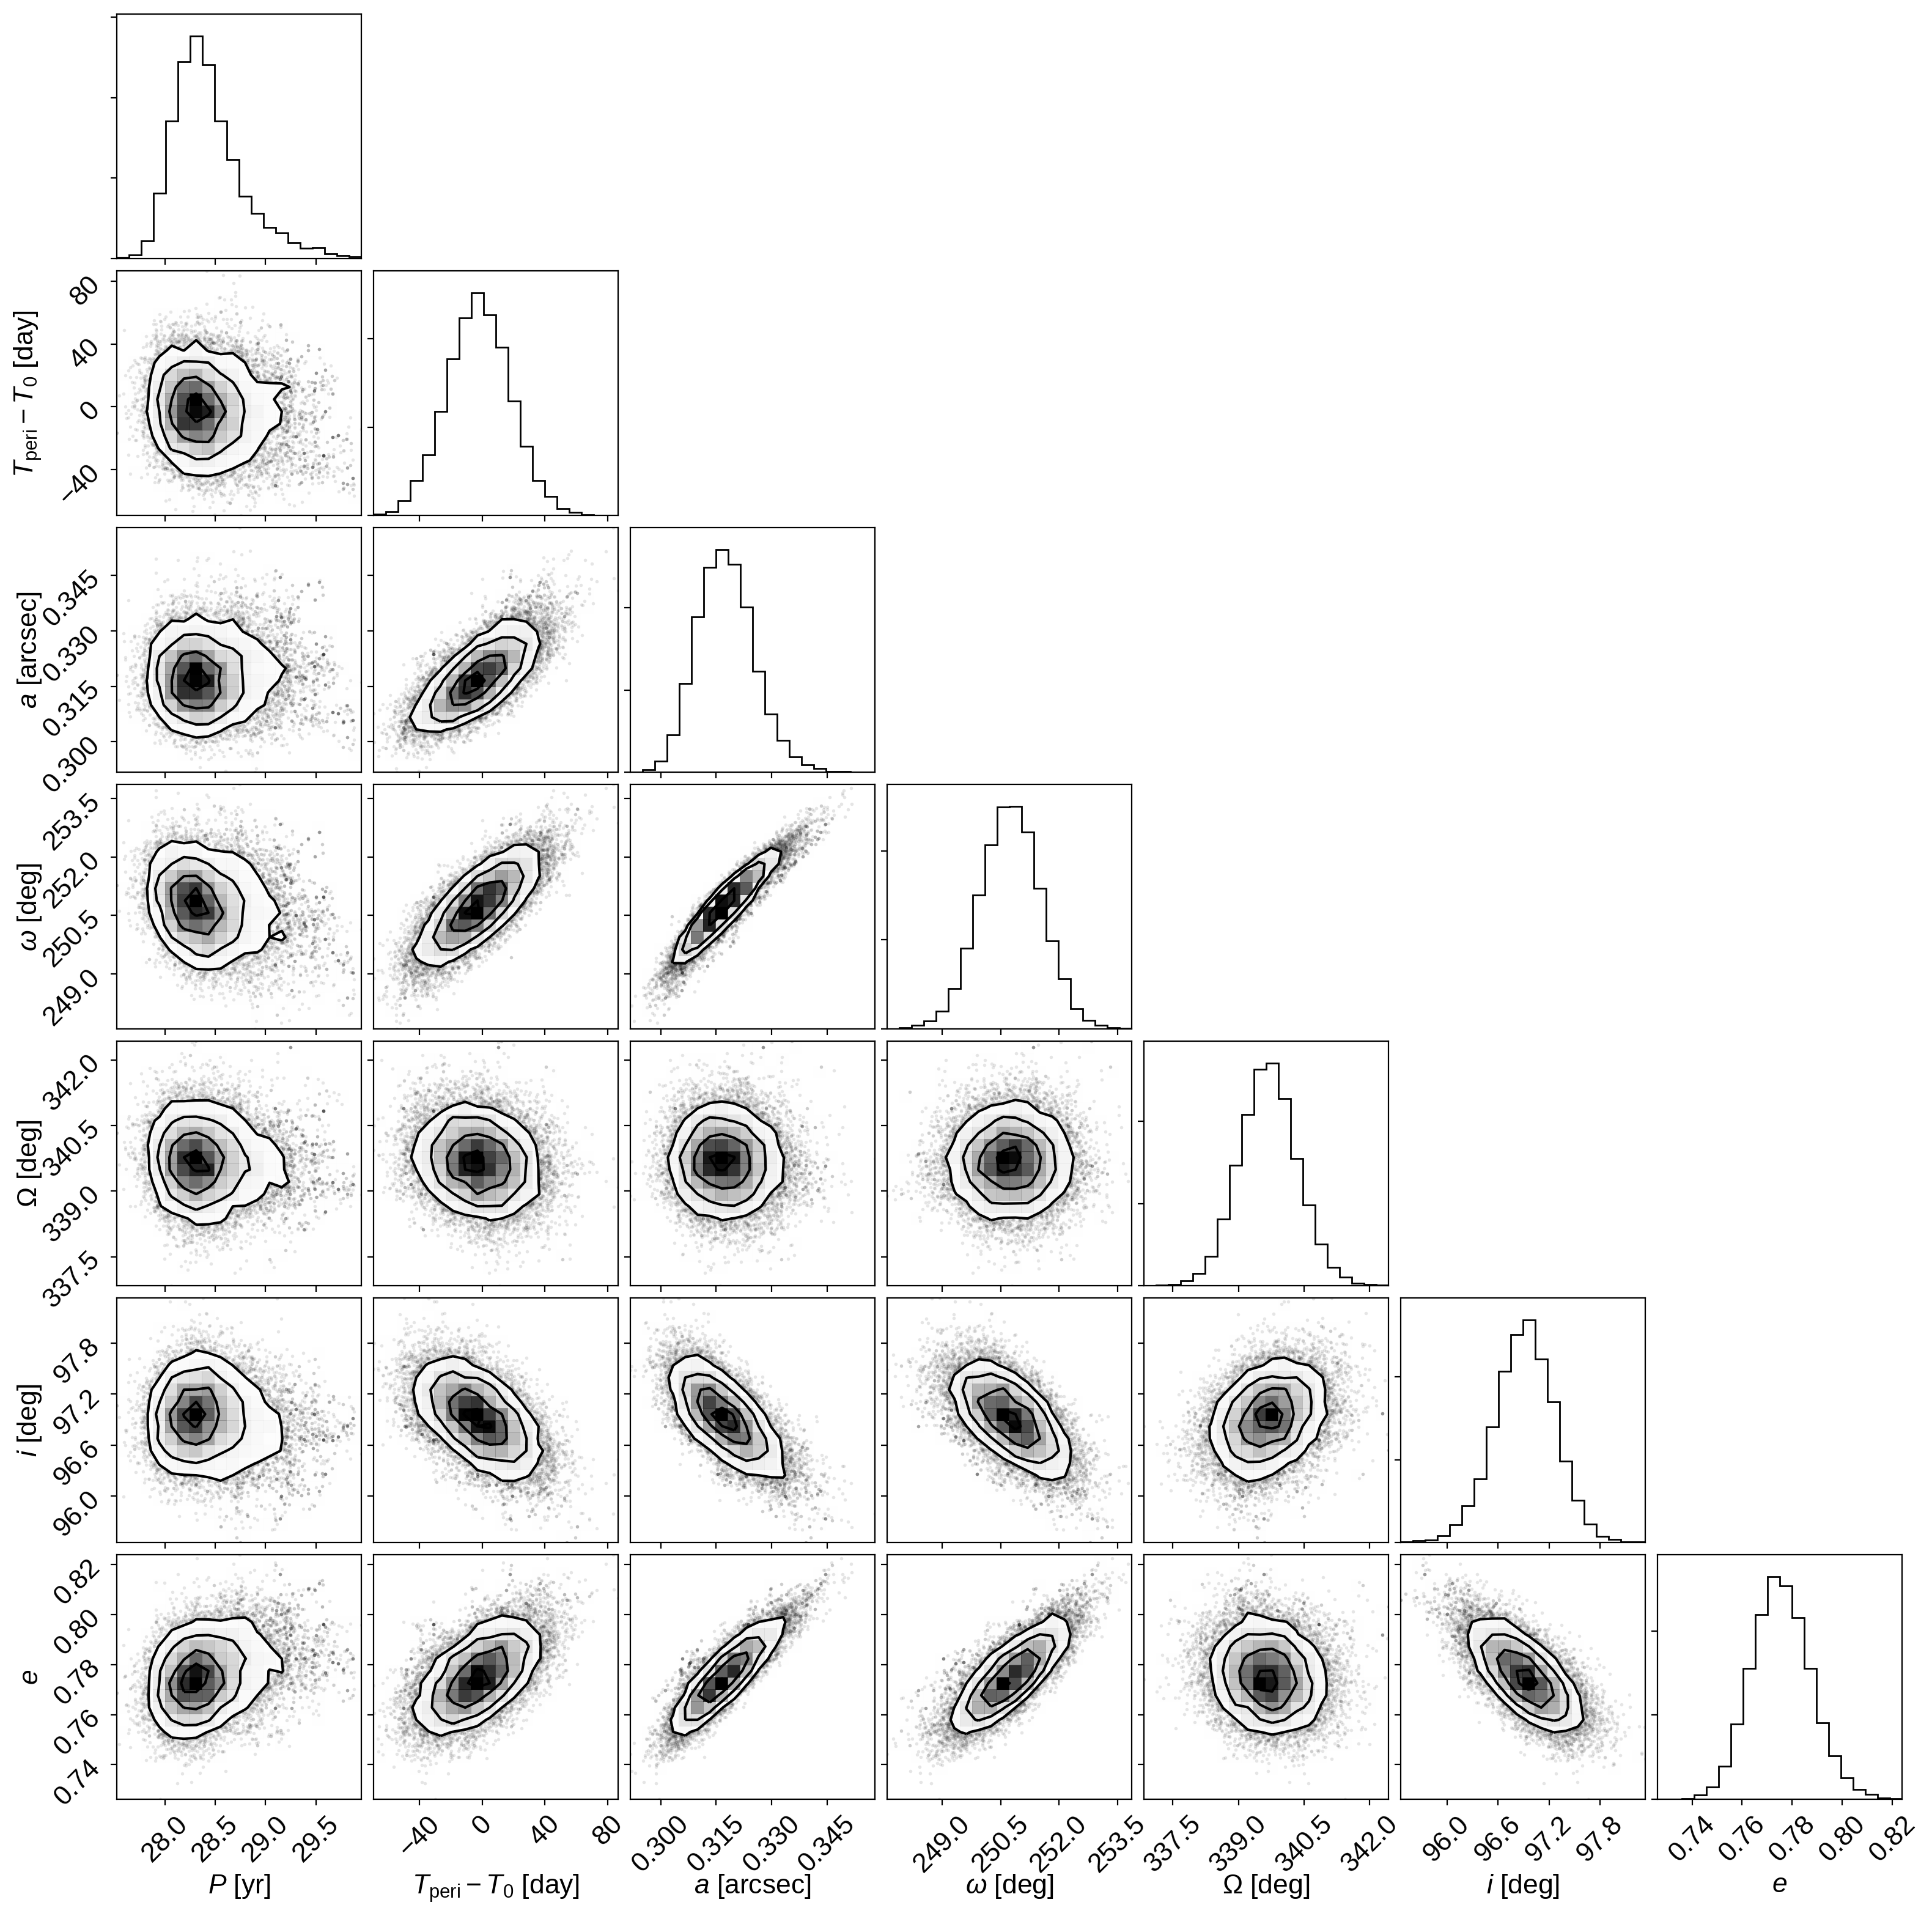

In [12]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
corner.corner(samples);

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

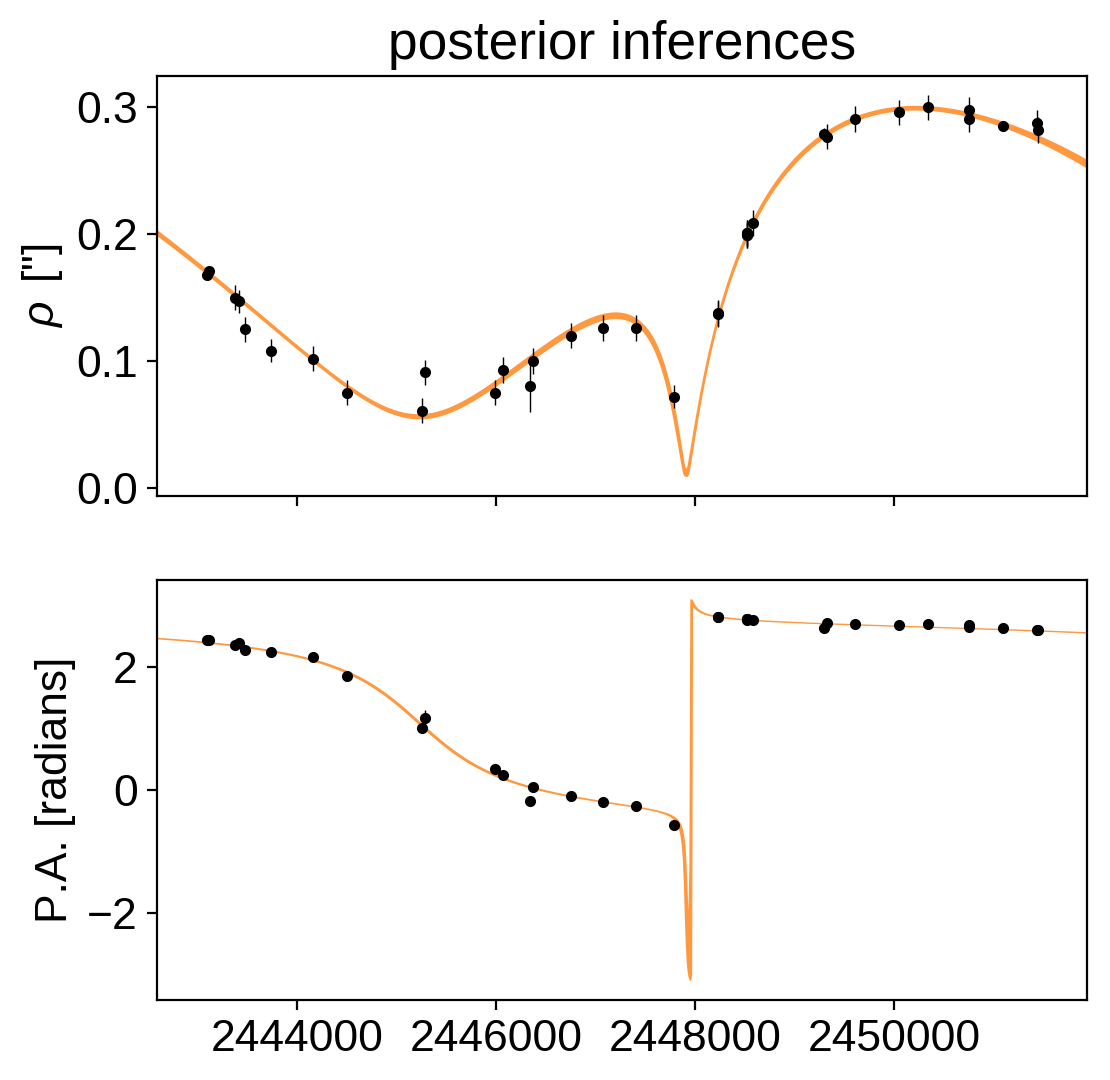

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'P.A. [radians]')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0)))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0)))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("posterior inferences");

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 107.64015029576193 -> 149.928601062681


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 149.928601062681 -> 170.426815184602


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 170.426815184602 -> 212.848015885607


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 212.848015885607 -> 213.28597911383866


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__', 'm_plx_interval__']


message: Optimization terminated successfully.
logp: 213.28597911383866 -> 217.80586833502514


In [15]:
np.random.seed(5432)
plx_sampler = xo.PyMC3Sampler(start=200, window=100, finish=500)
with plx_model:
    burnin = plx_sampler.tune(tune=4500, start=plx_map_soln,
                          step_kwargs=dict(target_accept=0.9))
    plx_trace = plx_sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:07, 100.37draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:09, 86.05draws/s] 

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:12, 63.94draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:12, 61.47draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:13, 55.76draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:00<00:14, 54.34draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:00<00:14, 53.54draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:00<00:13, 54.63draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:01<00:14, 53.16draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:01<00:14, 52.17draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:01<00:14, 51.37draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:13, 53.68draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:01<00:13, 52.84draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:01<00:13, 54.18draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:01<00:11, 62.47draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:01<00:12, 57.63draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:02<00:12, 55.07draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:02<00:11, 58.72draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:02<00:11, 58.49draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:02<00:12, 52.24draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:02<00:12, 54.59draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:02<00:11, 54.78draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:02<00:11, 56.18draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:02<00:11, 56.46draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:03<00:11, 55.74draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:03<00:11, 55.75draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:03<00:11, 54.80draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:03<00:11, 51.98draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:03<00:11, 55.02draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:03<00:11, 51.66draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:03<00:11, 52.21draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:03<00:11, 49.90draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:03<00:10, 54.33draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:04<00:10, 55.45draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:04<00:10, 52.19draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:04<00:10, 53.15draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:04<00:09, 57.85draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:04<00:10, 53.93draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:04<00:09, 55.54draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:04<00:09, 56.55draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:04<00:10, 52.14draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:04<00:09, 57.29draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:05<00:09, 54.07draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:05<00:09, 54.54draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:05<00:09, 54.85draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:05<00:08, 58.54draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:05<00:08, 61.24draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:05<00:08, 57.46draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:05<00:08, 57.69draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:05<00:08, 55.45draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:06<00:08, 56.04draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:06<00:08, 52.90draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:06<00:08, 55.52draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:06<00:07, 56.15draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:06<00:07, 57.16draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:06<00:07, 58.68draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:06<00:07, 58.53draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:06<00:07, 58.40draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:06<00:07, 56.71draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:07<00:06, 59.24draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:07<00:06, 60.90draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:07<00:06, 62.95draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:07<00:06, 58.98draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:07<00:06, 60.93draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:07<00:06, 58.60draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:07<00:06, 55.99draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:07<00:06, 58.81draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [00:08<00:06, 56.28draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:08<00:06, 55.12draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:08<00:06, 54.08draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:08<00:05, 57.53draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:08<00:06, 53.73draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:08<00:06, 52.69draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:08<00:05, 57.16draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:08<00:05, 52.59draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:08<00:05, 53.96draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [00:09<00:05, 52.37draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:09<00:05, 52.45draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:09<00:05, 51.81draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:09<00:05, 53.31draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [00:09<00:05, 54.16draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:09<00:04, 54.89draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:09<00:04, 57.79draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:09<00:04, 57.80draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:09<00:04, 57.78draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:10<00:04, 53.26draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [00:10<00:04, 53.71draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:10<00:04, 56.17draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [00:10<00:04, 52.99draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:10<00:03, 54.41draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:10<00:03, 55.69draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:10<00:03, 57.62draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [00:10<00:03, 57.78draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:10<00:03, 59.94draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:11<00:02, 64.60draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:11<00:02, 64.37draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:11<00:02, 66.14draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:11<00:02, 66.61draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:11<00:02, 61.46draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:11<00:02, 60.19draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:11<00:02, 56.28draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:11<00:02, 57.67draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:12<00:02, 54.17draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [00:12<00:02, 53.93draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:12<00:02, 52.60draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [00:12<00:01, 57.47draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:12<00:01, 55.44draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:12<00:01, 55.95draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:12<00:01, 53.97draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:12<00:01, 55.68draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [00:13<00:01, 54.66draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:13<00:01, 57.53draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:13<00:01, 55.21draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [00:13<00:00, 58.83draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:13<00:00, 56.55draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:13<00:00, 51.64draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:13<00:00, 55.04draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [00:13<00:00, 51.82draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:14<00:00, 47.17draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:14<00:00, 39.70draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:14<00:00, 38.78draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:14<00:00, 27.18draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:14<00:00, 54.46draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 13/408 [00:00<00:03, 112.61draws/s]

Sampling 4 chains:   5%|▍         | 20/408 [00:00<00:04, 91.60draws/s] 

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:05, 65.05draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:05, 66.13draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:00<00:05, 66.99draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:00<00:06, 56.84draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:00<00:05, 61.98draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:00<00:05, 62.98draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:01<00:05, 66.97draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:01<00:05, 57.77draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:01<00:05, 60.48draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:01<00:05, 62.88draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:01<00:04, 64.54draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:01<00:04, 61.65draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:01<00:04, 65.64draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:01<00:04, 64.69draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:01<00:04, 66.20draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:02<00:03, 68.52draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:02<00:04, 64.79draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:02<00:03, 68.33draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:02<00:03, 66.49draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:02<00:03, 69.94draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:02<00:03, 70.55draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:02<00:02, 75.00draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:02<00:02, 82.08draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:03<00:02, 83.03draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:03<00:02, 91.19draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:03<00:02, 85.26draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:03<00:01, 90.38draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:03<00:01, 88.50draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:03<00:01, 87.60draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:03<00:01, 87.06draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [00:03<00:01, 92.83draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:03<00:01, 95.31draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:04<00:01, 90.99draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:04<00:00, 93.23draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [00:04<00:00, 88.42draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:04<00:00, 80.82draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:04<00:00, 90.20draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:04<00:00, 87.05draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:04<00:00, 73.75draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:04<00:00, 70.62draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [00:05<00:00, 68.43draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [00:05<00:00, 72.52draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:05<00:00, 59.44draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:05<00:00, 71.82draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:00<00:01, 477.96draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:00<00:01, 496.62draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:00<00:01, 497.14draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:00<00:01, 515.60draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:00<00:01, 530.61draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:00<00:00, 543.98draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:00<00:00, 566.86draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:00<00:00, 561.37draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:00<00:00, 563.62draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:01<00:00, 589.57draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:01<00:00, 613.53draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [00:01<00:00, 616.01draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:01<00:00, 527.03draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:01<00:00, 517.83draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:00<00:03, 413.19draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:00<00:03, 412.73draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:00<00:03, 379.11draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:00<00:04, 336.77draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:00<00:04, 344.59draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:00<00:03, 377.85draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:00<00:03, 407.23draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:00<00:03, 400.41draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:00<00:03, 402.71draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [00:01<00:02, 415.14draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:01<00:02, 410.01draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [00:01<00:02, 405.61draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [00:01<00:02, 407.31draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [00:01<00:02, 432.54draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [00:01<00:02, 446.39draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [00:01<00:02, 454.54draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [00:01<00:01, 456.90draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [00:01<00:01, 452.59draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [00:01<00:01, 464.88draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [00:02<00:01, 479.77draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [00:02<00:01, 494.53draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [00:02<00:01, 483.16draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [00:02<00:01, 491.46draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [00:02<00:01, 480.03draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [00:02<00:00, 482.66draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [00:02<00:00, 507.43draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [00:02<00:00, 501.56draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [00:02<00:00, 499.26draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [00:02<00:00, 510.50draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [00:03<00:00, 475.86draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [00:03<00:00, 449.64draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [00:03<00:00, 401.56draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [00:03<00:00, 393.52draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [00:03<00:00, 359.00draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 424.80draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:00<00:09, 327.95draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:00<00:09, 331.37draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:00<00:09, 338.51draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:00<00:09, 334.72draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:00<00:09, 336.17draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:00<00:08, 344.62draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:00<00:07, 376.52draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [00:00<00:07, 392.74draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [00:00<00:07, 401.81draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [00:01<00:07, 400.64draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [00:01<00:06, 408.99draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [00:01<00:05, 454.63draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [00:01<00:05, 468.23draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [00:01<00:05, 440.19draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [00:01<00:06, 420.43draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [00:01<00:06, 416.89draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [00:01<00:06, 411.85draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [00:01<00:05, 433.17draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [00:01<00:05, 413.69draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [00:02<00:05, 409.35draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [00:02<00:05, 420.74draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [00:02<00:05, 436.75draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [00:02<00:04, 463.05draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [00:02<00:04, 455.29draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [00:02<00:04, 434.25draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [00:02<00:04, 417.98draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [00:02<00:04, 418.57draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [00:02<00:04, 436.84draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [00:03<00:04, 454.73draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [00:03<00:04, 448.19draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [00:03<00:04, 446.58draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [00:03<00:04, 438.42draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [00:03<00:03, 443.16draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [00:03<00:03, 458.40draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [00:03<00:03, 465.75draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [00:03<00:03, 477.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [00:03<00:03, 455.15draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [00:03<00:03, 474.25draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [00:04<00:03, 459.02draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [00:04<00:03, 444.88draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [00:04<00:03, 445.16draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [00:04<00:03, 428.10draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [00:04<00:02, 427.74draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [00:04<00:02, 433.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [00:04<00:02, 443.98draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [00:04<00:02, 481.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [00:04<00:02, 495.23draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [00:05<00:01, 503.12draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [00:05<00:01, 520.96draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [00:05<00:01, 521.39draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [00:05<00:01, 523.07draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [00:05<00:01, 552.36draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [00:05<00:01, 527.60draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [00:05<00:01, 499.78draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [00:05<00:01, 484.75draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [00:05<00:01, 482.81draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [00:06<00:00, 500.31draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [00:06<00:00, 484.18draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [00:06<00:00, 473.87draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [00:06<00:00, 470.37draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [00:06<00:00, 466.99draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [00:06<00:00, 486.46draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [00:06<00:00, 493.47draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [00:06<00:00, 512.50draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [00:06<00:00, 511.60draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [00:06<00:00, 534.07draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:07<00:00, 451.48draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 29/11208 [00:00<00:38, 288.87draws/s]

Sampling 4 chains:   1%|          | 69/11208 [00:00<00:35, 314.78draws/s]

Sampling 4 chains:   1%|          | 95/11208 [00:00<00:37, 293.90draws/s]

Sampling 4 chains:   1%|          | 121/11208 [00:00<00:39, 281.12draws/s]

Sampling 4 chains:   1%|▏         | 166/11208 [00:00<00:34, 315.85draws/s]

Sampling 4 chains:   2%|▏         | 207/11208 [00:00<00:32, 338.18draws/s]

Sampling 4 chains:   2%|▏         | 242/11208 [00:00<00:32, 339.48draws/s]

Sampling 4 chains:   3%|▎         | 284/11208 [00:00<00:30, 359.44draws/s]

Sampling 4 chains:   3%|▎         | 320/11208 [00:00<00:32, 337.51draws/s]

Sampling 4 chains:   3%|▎         | 369/11208 [00:01<00:29, 370.37draws/s]

Sampling 4 chains:   4%|▎         | 413/11208 [00:01<00:27, 387.01draws/s]

Sampling 4 chains:   4%|▍         | 464/11208 [00:01<00:25, 415.95draws/s]

Sampling 4 chains:   5%|▍         | 513/11208 [00:01<00:24, 431.45draws/s]

Sampling 4 chains:   5%|▍         | 558/11208 [00:01<00:24, 431.98draws/s]

Sampling 4 chains:   5%|▌         | 607/11208 [00:01<00:23, 447.07draws/s]

Sampling 4 chains:   6%|▌         | 653/11208 [00:01<00:23, 449.68draws/s]

Sampling 4 chains:   6%|▌         | 699/11208 [00:01<00:24, 426.92draws/s]

Sampling 4 chains:   7%|▋         | 743/11208 [00:01<00:24, 426.73draws/s]

Sampling 4 chains:   7%|▋         | 788/11208 [00:01<00:24, 431.65draws/s]

Sampling 4 chains:   8%|▊         | 842/11208 [00:02<00:22, 456.31draws/s]

Sampling 4 chains:   8%|▊         | 889/11208 [00:02<00:22, 458.90draws/s]

Sampling 4 chains:   8%|▊         | 940/11208 [00:02<00:21, 472.52draws/s]

Sampling 4 chains:   9%|▉         | 998/11208 [00:02<00:20, 495.28draws/s]

Sampling 4 chains:   9%|▉         | 1054/11208 [00:02<00:19, 512.94draws/s]

Sampling 4 chains:  10%|▉         | 1111/11208 [00:02<00:19, 527.55draws/s]

Sampling 4 chains:  10%|█         | 1165/11208 [00:02<00:20, 480.89draws/s]

Sampling 4 chains:  11%|█         | 1215/11208 [00:02<00:21, 466.30draws/s]

Sampling 4 chains:  11%|█▏        | 1263/11208 [00:02<00:21, 467.15draws/s]

Sampling 4 chains:  12%|█▏        | 1311/11208 [00:03<00:21, 462.31draws/s]

Sampling 4 chains:  12%|█▏        | 1358/11208 [00:03<00:21, 458.50draws/s]

Sampling 4 chains:  13%|█▎        | 1410/11208 [00:03<00:20, 473.34draws/s]

Sampling 4 chains:  13%|█▎        | 1458/11208 [00:03<00:21, 461.21draws/s]

Sampling 4 chains:  13%|█▎        | 1510/11208 [00:03<00:20, 475.79draws/s]

Sampling 4 chains:  14%|█▍        | 1559/11208 [00:03<00:20, 475.68draws/s]

Sampling 4 chains:  14%|█▍        | 1607/11208 [00:03<00:20, 458.88draws/s]

Sampling 4 chains:  15%|█▍        | 1655/11208 [00:03<00:20, 463.89draws/s]

Sampling 4 chains:  15%|█▌        | 1702/11208 [00:03<00:21, 449.64draws/s]

Sampling 4 chains:  16%|█▌        | 1759/11208 [00:03<00:19, 478.74draws/s]

Sampling 4 chains:  16%|█▌        | 1810/11208 [00:04<00:19, 485.91draws/s]

Sampling 4 chains:  17%|█▋        | 1860/11208 [00:04<00:19, 468.91draws/s]

Sampling 4 chains:  17%|█▋        | 1908/11208 [00:04<00:20, 462.61draws/s]

Sampling 4 chains:  18%|█▊        | 1964/11208 [00:04<00:18, 486.72draws/s]

Sampling 4 chains:  18%|█▊        | 2027/11208 [00:04<00:17, 517.92draws/s]

Sampling 4 chains:  19%|█▊        | 2080/11208 [00:04<00:17, 510.08draws/s]

Sampling 4 chains:  19%|█▉        | 2132/11208 [00:04<00:18, 493.50draws/s]

Sampling 4 chains:  19%|█▉        | 2182/11208 [00:04<00:18, 491.32draws/s]

Sampling 4 chains:  20%|█▉        | 2232/11208 [00:04<00:18, 486.69draws/s]

Sampling 4 chains:  20%|██        | 2282/11208 [00:05<00:18, 488.76draws/s]

Sampling 4 chains:  21%|██        | 2336/11208 [00:05<00:17, 501.44draws/s]

Sampling 4 chains:  21%|██▏       | 2387/11208 [00:05<00:18, 477.99draws/s]

Sampling 4 chains:  22%|██▏       | 2443/11208 [00:05<00:17, 498.93draws/s]

Sampling 4 chains:  22%|██▏       | 2495/11208 [00:05<00:17, 504.36draws/s]

Sampling 4 chains:  23%|██▎       | 2550/11208 [00:05<00:16, 514.82draws/s]

Sampling 4 chains:  23%|██▎       | 2602/11208 [00:05<00:17, 488.65draws/s]

Sampling 4 chains:  24%|██▎       | 2652/11208 [00:05<00:17, 475.42draws/s]

Sampling 4 chains:  24%|██▍       | 2702/11208 [00:05<00:17, 481.41draws/s]

Sampling 4 chains:  25%|██▍       | 2751/11208 [00:06<00:18, 467.53draws/s]

Sampling 4 chains:  25%|██▍       | 2799/11208 [00:06<00:18, 464.78draws/s]

Sampling 4 chains:  25%|██▌       | 2853/11208 [00:06<00:17, 481.96draws/s]

Sampling 4 chains:  26%|██▌       | 2902/11208 [00:06<00:17, 476.25draws/s]

Sampling 4 chains:  26%|██▋       | 2957/11208 [00:06<00:16, 494.56draws/s]

Sampling 4 chains:  27%|██▋       | 3008/11208 [00:06<00:16, 497.93draws/s]

Sampling 4 chains:  27%|██▋       | 3059/11208 [00:06<00:16, 492.54draws/s]

Sampling 4 chains:  28%|██▊       | 3109/11208 [00:06<00:16, 490.69draws/s]

Sampling 4 chains:  28%|██▊       | 3159/11208 [00:06<00:16, 484.94draws/s]

Sampling 4 chains:  29%|██▊       | 3215/11208 [00:06<00:15, 504.05draws/s]

Sampling 4 chains:  29%|██▉       | 3266/11208 [00:07<00:16, 481.12draws/s]

Sampling 4 chains:  30%|██▉       | 3317/11208 [00:07<00:16, 488.88draws/s]

Sampling 4 chains:  30%|███       | 3376/11208 [00:07<00:15, 513.79draws/s]

Sampling 4 chains:  31%|███       | 3428/11208 [00:07<00:15, 496.38draws/s]

Sampling 4 chains:  31%|███       | 3481/11208 [00:07<00:15, 505.40draws/s]

Sampling 4 chains:  32%|███▏      | 3532/11208 [00:07<00:15, 482.78draws/s]

Sampling 4 chains:  32%|███▏      | 3581/11208 [00:07<00:16, 470.46draws/s]

Sampling 4 chains:  32%|███▏      | 3632/11208 [00:07<00:15, 477.52draws/s]

Sampling 4 chains:  33%|███▎      | 3683/11208 [00:07<00:15, 486.72draws/s]

Sampling 4 chains:  33%|███▎      | 3732/11208 [00:08<00:15, 474.79draws/s]

Sampling 4 chains:  34%|███▍      | 3788/11208 [00:08<00:14, 496.26draws/s]

Sampling 4 chains:  34%|███▍      | 3839/11208 [00:08<00:14, 496.72draws/s]

Sampling 4 chains:  35%|███▍      | 3891/11208 [00:08<00:14, 501.84draws/s]

Sampling 4 chains:  35%|███▌      | 3942/11208 [00:08<00:15, 481.58draws/s]

Sampling 4 chains:  36%|███▌      | 3991/11208 [00:08<00:15, 467.70draws/s]

Sampling 4 chains:  36%|███▌      | 4043/11208 [00:08<00:14, 480.19draws/s]

Sampling 4 chains:  37%|███▋      | 4099/11208 [00:08<00:14, 500.27draws/s]

Sampling 4 chains:  37%|███▋      | 4152/11208 [00:08<00:13, 504.80draws/s]

Sampling 4 chains:  38%|███▊      | 4203/11208 [00:08<00:14, 492.79draws/s]

Sampling 4 chains:  38%|███▊      | 4253/11208 [00:09<00:14, 471.15draws/s]

Sampling 4 chains:  38%|███▊      | 4309/11208 [00:09<00:13, 492.95draws/s]

Sampling 4 chains:  39%|███▉      | 4359/11208 [00:09<00:13, 490.85draws/s]

Sampling 4 chains:  39%|███▉      | 4412/11208 [00:09<00:13, 498.92draws/s]

Sampling 4 chains:  40%|███▉      | 4463/11208 [00:09<00:14, 475.86draws/s]

Sampling 4 chains:  40%|████      | 4512/11208 [00:09<00:14, 473.47draws/s]

Sampling 4 chains:  41%|████      | 4563/11208 [00:09<00:13, 483.79draws/s]

Sampling 4 chains:  41%|████      | 4616/11208 [00:09<00:13, 493.84draws/s]

Sampling 4 chains:  42%|████▏     | 4666/11208 [00:09<00:13, 487.22draws/s]

Sampling 4 chains:  42%|████▏     | 4715/11208 [00:10<00:13, 481.55draws/s]

Sampling 4 chains:  43%|████▎     | 4764/11208 [00:10<00:13, 481.35draws/s]

Sampling 4 chains:  43%|████▎     | 4819/11208 [00:10<00:12, 496.46draws/s]

Sampling 4 chains:  43%|████▎     | 4872/11208 [00:10<00:12, 503.08draws/s]

Sampling 4 chains:  44%|████▍     | 4923/11208 [00:10<00:12, 501.12draws/s]

Sampling 4 chains:  44%|████▍     | 4974/11208 [00:10<00:13, 466.50draws/s]

Sampling 4 chains:  45%|████▍     | 5022/11208 [00:10<00:13, 452.06draws/s]

Sampling 4 chains:  45%|████▌     | 5068/11208 [00:10<00:14, 426.78draws/s]

Sampling 4 chains:  46%|████▌     | 5113/11208 [00:10<00:14, 432.53draws/s]

Sampling 4 chains:  46%|████▌     | 5164/11208 [00:10<00:13, 451.51draws/s]

Sampling 4 chains:  46%|████▋     | 5210/11208 [00:11<00:13, 451.73draws/s]

Sampling 4 chains:  47%|████▋     | 5256/11208 [00:11<00:13, 447.59draws/s]

Sampling 4 chains:  47%|████▋     | 5307/11208 [00:11<00:12, 463.54draws/s]

Sampling 4 chains:  48%|████▊     | 5354/11208 [00:11<00:12, 464.42draws/s]

Sampling 4 chains:  48%|████▊     | 5405/11208 [00:11<00:12, 471.29draws/s]

Sampling 4 chains:  49%|████▊     | 5453/11208 [00:11<00:12, 466.01draws/s]

Sampling 4 chains:  49%|████▉     | 5502/11208 [00:11<00:12, 470.02draws/s]

Sampling 4 chains:  50%|████▉     | 5555/11208 [00:11<00:11, 485.97draws/s]

Sampling 4 chains:  50%|█████     | 5607/11208 [00:11<00:11, 494.04draws/s]

Sampling 4 chains:  50%|█████     | 5660/11208 [00:12<00:11, 503.46draws/s]

Sampling 4 chains:  51%|█████     | 5717/11208 [00:12<00:10, 520.08draws/s]

Sampling 4 chains:  51%|█████▏    | 5770/11208 [00:12<00:10, 510.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5825/11208 [00:12<00:10, 521.08draws/s]

Sampling 4 chains:  52%|█████▏    | 5878/11208 [00:12<00:10, 508.97draws/s]

Sampling 4 chains:  53%|█████▎    | 5930/11208 [00:12<00:10, 492.36draws/s]

Sampling 4 chains:  53%|█████▎    | 5980/11208 [00:12<00:11, 470.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6029/11208 [00:12<00:10, 475.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6078/11208 [00:12<00:10, 479.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6140/11208 [00:12<00:09, 514.07draws/s]

Sampling 4 chains:  55%|█████▌    | 6196/11208 [00:13<00:09, 525.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6250/11208 [00:13<00:09, 518.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6303/11208 [00:13<00:09, 518.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6365/11208 [00:13<00:08, 544.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6427/11208 [00:13<00:08, 564.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6485/11208 [00:13<00:08, 560.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6542/11208 [00:13<00:08, 535.18draws/s]

Sampling 4 chains:  59%|█████▉    | 6597/11208 [00:13<00:08, 526.90draws/s]

Sampling 4 chains:  59%|█████▉    | 6651/11208 [00:13<00:09, 501.44draws/s]

Sampling 4 chains:  60%|█████▉    | 6707/11208 [00:14<00:08, 516.66draws/s]

Sampling 4 chains:  60%|██████    | 6760/11208 [00:14<00:08, 517.35draws/s]

Sampling 4 chains:  61%|██████    | 6813/11208 [00:14<00:08, 508.46draws/s]

Sampling 4 chains:  61%|██████▏   | 6865/11208 [00:14<00:08, 503.05draws/s]

Sampling 4 chains:  62%|██████▏   | 6916/11208 [00:14<00:08, 489.98draws/s]

Sampling 4 chains:  62%|██████▏   | 6966/11208 [00:14<00:08, 482.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7015/11208 [00:14<00:08, 477.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7063/11208 [00:14<00:08, 460.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7110/11208 [00:14<00:08, 458.57draws/s]

Sampling 4 chains:  64%|██████▍   | 7164/11208 [00:14<00:08, 479.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7213/11208 [00:15<00:08, 470.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7264/11208 [00:15<00:08, 481.65draws/s]

Sampling 4 chains:  65%|██████▌   | 7313/11208 [00:15<00:08, 476.32draws/s]

Sampling 4 chains:  66%|██████▌   | 7370/11208 [00:15<00:07, 500.93draws/s]

Sampling 4 chains:  66%|██████▋   | 7428/11208 [00:15<00:07, 521.44draws/s]

Sampling 4 chains:  67%|██████▋   | 7490/11208 [00:15<00:06, 545.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7546/11208 [00:15<00:06, 526.22draws/s]

Sampling 4 chains:  68%|██████▊   | 7600/11208 [00:15<00:06, 525.03draws/s]

Sampling 4 chains:  68%|██████▊   | 7656/11208 [00:15<00:06, 533.87draws/s]

Sampling 4 chains:  69%|██████▉   | 7710/11208 [00:16<00:06, 517.69draws/s]

Sampling 4 chains:  69%|██████▉   | 7763/11208 [00:16<00:06, 517.66draws/s]

Sampling 4 chains:  70%|██████▉   | 7816/11208 [00:16<00:06, 491.08draws/s]

Sampling 4 chains:  70%|███████   | 7866/11208 [00:16<00:06, 482.67draws/s]

Sampling 4 chains:  71%|███████   | 7915/11208 [00:16<00:06, 483.98draws/s]

Sampling 4 chains:  71%|███████   | 7964/11208 [00:16<00:06, 478.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8014/11208 [00:16<00:06, 484.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8070/11208 [00:16<00:06, 503.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8133/11208 [00:16<00:05, 532.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8187/11208 [00:16<00:05, 516.88draws/s]

Sampling 4 chains:  74%|███████▎  | 8248/11208 [00:17<00:05, 540.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8308/11208 [00:17<00:05, 553.40draws/s]

Sampling 4 chains:  75%|███████▍  | 8364/11208 [00:17<00:05, 540.78draws/s]

Sampling 4 chains:  75%|███████▌  | 8419/11208 [00:17<00:05, 538.37draws/s]

Sampling 4 chains:  76%|███████▌  | 8475/11208 [00:17<00:05, 544.15draws/s]

Sampling 4 chains:  76%|███████▌  | 8530/11208 [00:17<00:05, 532.24draws/s]

Sampling 4 chains:  77%|███████▋  | 8584/11208 [00:17<00:04, 528.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8642/11208 [00:17<00:04, 540.30draws/s]

Sampling 4 chains:  78%|███████▊  | 8701/11208 [00:17<00:04, 553.17draws/s]

Sampling 4 chains:  78%|███████▊  | 8757/11208 [00:18<00:04, 543.83draws/s]

Sampling 4 chains:  79%|███████▊  | 8812/11208 [00:18<00:04, 541.60draws/s]

Sampling 4 chains:  79%|███████▉  | 8867/11208 [00:18<00:04, 535.77draws/s]

Sampling 4 chains:  80%|███████▉  | 8927/11208 [00:18<00:04, 552.00draws/s]

Sampling 4 chains:  80%|████████  | 8983/11208 [00:18<00:04, 516.36draws/s]

Sampling 4 chains:  81%|████████  | 9036/11208 [00:18<00:04, 479.41draws/s]

Sampling 4 chains:  81%|████████  | 9090/11208 [00:18<00:04, 495.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9141/11208 [00:18<00:04, 485.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9191/11208 [00:18<00:04, 483.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9241/11208 [00:19<00:04, 483.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9292/11208 [00:19<00:03, 486.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9341/11208 [00:19<00:03, 475.93draws/s]

Sampling 4 chains:  84%|████████▍ | 9389/11208 [00:19<00:03, 458.12draws/s]

Sampling 4 chains:  84%|████████▍ | 9439/11208 [00:19<00:03, 469.35draws/s]

Sampling 4 chains:  85%|████████▍ | 9501/11208 [00:19<00:03, 505.32draws/s]

Sampling 4 chains:  85%|████████▌ | 9572/11208 [00:19<00:02, 552.02draws/s]

Sampling 4 chains:  86%|████████▌ | 9634/11208 [00:19<00:02, 569.14draws/s]

Sampling 4 chains:  86%|████████▋ | 9693/11208 [00:19<00:02, 553.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9750/11208 [00:19<00:02, 533.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9805/11208 [00:20<00:02, 514.21draws/s]

Sampling 4 chains:  88%|████████▊ | 9858/11208 [00:20<00:02, 491.83draws/s]

Sampling 4 chains:  88%|████████▊ | 9911/11208 [00:20<00:02, 502.25draws/s]

Sampling 4 chains:  89%|████████▉ | 9963/11208 [00:20<00:02, 506.52draws/s]

Sampling 4 chains:  89%|████████▉ | 10015/11208 [00:20<00:02, 506.69draws/s]

Sampling 4 chains:  90%|████████▉ | 10066/11208 [00:20<00:02, 493.38draws/s]

Sampling 4 chains:  90%|█████████ | 10117/11208 [00:20<00:02, 497.58draws/s]

Sampling 4 chains:  91%|█████████ | 10170/11208 [00:20<00:02, 506.00draws/s]

Sampling 4 chains:  91%|█████████▏| 10232/11208 [00:20<00:01, 533.74draws/s]

Sampling 4 chains:  92%|█████████▏| 10289/11208 [00:21<00:01, 543.68draws/s]

Sampling 4 chains:  92%|█████████▏| 10344/11208 [00:21<00:01, 542.73draws/s]

Sampling 4 chains:  93%|█████████▎| 10399/11208 [00:21<00:01, 543.54draws/s]

Sampling 4 chains:  93%|█████████▎| 10454/11208 [00:21<00:01, 531.91draws/s]

Sampling 4 chains:  94%|█████████▍| 10508/11208 [00:21<00:01, 521.89draws/s]

Sampling 4 chains:  94%|█████████▍| 10570/11208 [00:21<00:01, 546.70draws/s]

Sampling 4 chains:  95%|█████████▍| 10634/11208 [00:21<00:01, 570.54draws/s]

Sampling 4 chains:  95%|█████████▌| 10692/11208 [00:21<00:00, 556.39draws/s]

Sampling 4 chains:  96%|█████████▌| 10749/11208 [00:21<00:00, 528.60draws/s]

Sampling 4 chains:  96%|█████████▋| 10803/11208 [00:21<00:00, 508.39draws/s]

Sampling 4 chains:  97%|█████████▋| 10855/11208 [00:22<00:00, 510.41draws/s]

Sampling 4 chains:  97%|█████████▋| 10907/11208 [00:22<00:00, 444.78draws/s]

Sampling 4 chains:  98%|█████████▊| 10954/11208 [00:22<00:00, 415.34draws/s]

Sampling 4 chains:  98%|█████████▊| 10998/11208 [00:22<00:00, 338.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11036/11208 [00:22<00:00, 306.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11070/11208 [00:22<00:00, 295.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11102/11208 [00:22<00:00, 265.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11131/11208 [00:23<00:00, 252.39draws/s]

Sampling 4 chains: 100%|█████████▉| 11158/11208 [00:23<00:00, 256.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11188/11208 [00:23<00:00, 267.76draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [00:23<00:00, 478.69draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 28/2008 [00:00<00:07, 276.11draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:00<00:07, 273.45draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:00<00:06, 289.11draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:00<00:06, 299.01draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:00<00:05, 333.09draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:00<00:04, 368.36draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:00<00:04, 386.17draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:00<00:04, 402.63draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [00:00<00:04, 382.06draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [00:01<00:03, 408.51draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [00:01<00:03, 402.28draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [00:01<00:03, 403.14draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [00:01<00:03, 419.93draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [00:01<00:03, 435.06draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [00:01<00:03, 446.36draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [00:01<00:03, 441.89draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [00:01<00:02, 461.78draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [00:01<00:02, 465.70draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [00:01<00:02, 467.10draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [00:02<00:02, 473.28draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [00:02<00:02, 466.17draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [00:02<00:02, 462.81draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [00:02<00:02, 477.33draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [00:02<00:01, 486.53draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [00:02<00:01, 480.58draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [00:02<00:01, 487.82draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [00:02<00:01, 497.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [00:02<00:01, 480.33draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [00:02<00:01, 485.26draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [00:03<00:01, 479.33draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [00:03<00:01, 459.36draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [00:03<00:01, 469.58draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [00:03<00:01, 474.29draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [00:03<00:00, 490.34draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [00:03<00:00, 480.59draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [00:03<00:00, 473.52draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [00:03<00:00, 454.62draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [00:03<00:00, 465.54draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [00:04<00:00, 477.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [00:04<00:00, 389.67draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [00:04<00:00, 299.75draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [00:04<00:00, 283.54draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [00:04<00:00, 231.99draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [00:05<00:00, 177.12draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 29/16000 [00:00<00:55, 285.33draws/s]

Sampling 4 chains:   0%|          | 68/16000 [00:00<00:51, 310.14draws/s]

Sampling 4 chains:   1%|          | 109/16000 [00:00<00:47, 333.75draws/s]

Sampling 4 chains:   1%|          | 152/16000 [00:00<00:44, 353.48draws/s]

Sampling 4 chains:   1%|          | 194/16000 [00:00<00:42, 369.42draws/s]

Sampling 4 chains:   1%|▏         | 233/16000 [00:00<00:42, 370.89draws/s]

Sampling 4 chains:   2%|▏         | 275/16000 [00:00<00:41, 382.00draws/s]

Sampling 4 chains:   2%|▏         | 319/16000 [00:00<00:39, 397.49draws/s]

Sampling 4 chains:   2%|▏         | 360/16000 [00:00<00:39, 400.53draws/s]

Sampling 4 chains:   2%|▎         | 400/16000 [00:01<00:39, 393.55draws/s]

Sampling 4 chains:   3%|▎         | 442/16000 [00:01<00:38, 399.35draws/s]

Sampling 4 chains:   3%|▎         | 484/16000 [00:01<00:38, 404.54draws/s]

Sampling 4 chains:   3%|▎         | 525/16000 [00:01<00:38, 403.49draws/s]

Sampling 4 chains:   4%|▎         | 567/16000 [00:01<00:37, 406.79draws/s]

Sampling 4 chains:   4%|▍         | 610/16000 [00:01<00:37, 410.15draws/s]

Sampling 4 chains:   4%|▍         | 651/16000 [00:01<00:37, 406.91draws/s]

Sampling 4 chains:   4%|▍         | 693/16000 [00:01<00:37, 410.09draws/s]

Sampling 4 chains:   5%|▍         | 734/16000 [00:01<00:37, 405.57draws/s]

Sampling 4 chains:   5%|▍         | 777/16000 [00:01<00:37, 409.53draws/s]

Sampling 4 chains:   5%|▌         | 818/16000 [00:02<00:37, 409.46draws/s]

Sampling 4 chains:   5%|▌         | 859/16000 [00:02<00:37, 408.50draws/s]

Sampling 4 chains:   6%|▌         | 900/16000 [00:02<00:37, 404.85draws/s]

Sampling 4 chains:   6%|▌         | 941/16000 [00:02<00:37, 402.59draws/s]

Sampling 4 chains:   6%|▌         | 982/16000 [00:02<00:37, 401.88draws/s]

Sampling 4 chains:   6%|▋         | 1023/16000 [00:02<00:38, 393.85draws/s]

Sampling 4 chains:   7%|▋         | 1063/16000 [00:02<00:38, 388.17draws/s]

Sampling 4 chains:   7%|▋         | 1104/16000 [00:02<00:37, 392.21draws/s]

Sampling 4 chains:   7%|▋         | 1145/16000 [00:02<00:37, 396.19draws/s]

Sampling 4 chains:   7%|▋         | 1186/16000 [00:02<00:37, 397.63draws/s]

Sampling 4 chains:   8%|▊         | 1229/16000 [00:03<00:36, 406.46draws/s]

Sampling 4 chains:   8%|▊         | 1270/16000 [00:03<00:36, 407.06draws/s]

Sampling 4 chains:   8%|▊         | 1312/16000 [00:03<00:35, 410.56draws/s]

Sampling 4 chains:   8%|▊         | 1354/16000 [00:03<00:36, 405.40draws/s]

Sampling 4 chains:   9%|▊         | 1396/16000 [00:03<00:36, 403.83draws/s]

Sampling 4 chains:   9%|▉         | 1438/16000 [00:03<00:35, 407.04draws/s]

Sampling 4 chains:   9%|▉         | 1479/16000 [00:03<00:35, 405.21draws/s]

Sampling 4 chains:  10%|▉         | 1520/16000 [00:03<00:36, 398.10draws/s]

Sampling 4 chains:  10%|▉         | 1564/16000 [00:03<00:35, 409.22draws/s]

Sampling 4 chains:  10%|█         | 1607/16000 [00:03<00:34, 414.31draws/s]

Sampling 4 chains:  10%|█         | 1649/16000 [00:04<00:34, 412.18draws/s]

Sampling 4 chains:  11%|█         | 1691/16000 [00:04<00:34, 409.35draws/s]

Sampling 4 chains:  11%|█         | 1732/16000 [00:04<00:35, 404.91draws/s]

Sampling 4 chains:  11%|█         | 1773/16000 [00:04<00:35, 398.15draws/s]

Sampling 4 chains:  11%|█▏        | 1815/16000 [00:04<00:35, 402.64draws/s]

Sampling 4 chains:  12%|█▏        | 1857/16000 [00:04<00:34, 407.39draws/s]

Sampling 4 chains:  12%|█▏        | 1901/16000 [00:04<00:33, 415.90draws/s]

Sampling 4 chains:  12%|█▏        | 1944/16000 [00:04<00:33, 418.30draws/s]

Sampling 4 chains:  12%|█▏        | 1987/16000 [00:04<00:33, 419.15draws/s]

Sampling 4 chains:  13%|█▎        | 2029/16000 [00:05<00:33, 418.02draws/s]

Sampling 4 chains:  13%|█▎        | 2071/16000 [00:05<00:33, 417.09draws/s]

Sampling 4 chains:  13%|█▎        | 2115/16000 [00:05<00:32, 421.99draws/s]

Sampling 4 chains:  13%|█▎        | 2158/16000 [00:05<00:33, 416.13draws/s]

Sampling 4 chains:  14%|█▍        | 2201/16000 [00:05<00:33, 416.07draws/s]

Sampling 4 chains:  14%|█▍        | 2243/16000 [00:05<00:33, 412.67draws/s]

Sampling 4 chains:  14%|█▍        | 2285/16000 [00:05<00:33, 412.13draws/s]

Sampling 4 chains:  15%|█▍        | 2329/16000 [00:05<00:32, 418.18draws/s]

Sampling 4 chains:  15%|█▍        | 2371/16000 [00:05<00:32, 413.88draws/s]

Sampling 4 chains:  15%|█▌        | 2413/16000 [00:05<00:32, 414.56draws/s]

Sampling 4 chains:  15%|█▌        | 2455/16000 [00:06<00:32, 415.90draws/s]

Sampling 4 chains:  16%|█▌        | 2497/16000 [00:06<00:33, 403.35draws/s]

Sampling 4 chains:  16%|█▌        | 2538/16000 [00:06<00:33, 399.63draws/s]

Sampling 4 chains:  16%|█▌        | 2579/16000 [00:06<00:33, 401.68draws/s]

Sampling 4 chains:  16%|█▋        | 2620/16000 [00:06<00:33, 403.80draws/s]

Sampling 4 chains:  17%|█▋        | 2661/16000 [00:06<00:33, 401.01draws/s]

Sampling 4 chains:  17%|█▋        | 2704/16000 [00:06<00:32, 408.46draws/s]

Sampling 4 chains:  17%|█▋        | 2746/16000 [00:06<00:32, 411.18draws/s]

Sampling 4 chains:  17%|█▋        | 2788/16000 [00:06<00:32, 407.39draws/s]

Sampling 4 chains:  18%|█▊        | 2830/16000 [00:06<00:32, 410.56draws/s]

Sampling 4 chains:  18%|█▊        | 2873/16000 [00:07<00:31, 415.51draws/s]

Sampling 4 chains:  18%|█▊        | 2917/16000 [00:07<00:31, 420.93draws/s]

Sampling 4 chains:  18%|█▊        | 2960/16000 [00:07<00:31, 419.04draws/s]

Sampling 4 chains:  19%|█▉        | 3005/16000 [00:07<00:30, 427.39draws/s]

Sampling 4 chains:  19%|█▉        | 3048/16000 [00:07<00:30, 422.81draws/s]

Sampling 4 chains:  19%|█▉        | 3091/16000 [00:07<00:30, 424.00draws/s]

Sampling 4 chains:  20%|█▉        | 3134/16000 [00:07<00:30, 421.79draws/s]

Sampling 4 chains:  20%|█▉        | 3177/16000 [00:07<00:31, 411.70draws/s]

Sampling 4 chains:  20%|██        | 3219/16000 [00:07<00:31, 404.83draws/s]

Sampling 4 chains:  20%|██        | 3260/16000 [00:08<00:31, 401.53draws/s]

Sampling 4 chains:  21%|██        | 3302/16000 [00:08<00:31, 406.49draws/s]

Sampling 4 chains:  21%|██        | 3345/16000 [00:08<00:30, 410.11draws/s]

Sampling 4 chains:  21%|██        | 3388/16000 [00:08<00:30, 413.39draws/s]

Sampling 4 chains:  21%|██▏       | 3432/16000 [00:08<00:29, 419.18draws/s]

Sampling 4 chains:  22%|██▏       | 3474/16000 [00:08<00:29, 418.26draws/s]

Sampling 4 chains:  22%|██▏       | 3517/16000 [00:08<00:29, 419.40draws/s]

Sampling 4 chains:  22%|██▏       | 3559/16000 [00:08<00:30, 413.92draws/s]

Sampling 4 chains:  23%|██▎       | 3606/16000 [00:08<00:29, 424.96draws/s]

Sampling 4 chains:  23%|██▎       | 3655/16000 [00:08<00:28, 437.70draws/s]

Sampling 4 chains:  23%|██▎       | 3699/16000 [00:09<00:28, 432.47draws/s]

Sampling 4 chains:  23%|██▎       | 3743/16000 [00:09<00:29, 422.54draws/s]

Sampling 4 chains:  24%|██▎       | 3786/16000 [00:09<00:29, 420.98draws/s]

Sampling 4 chains:  24%|██▍       | 3829/16000 [00:09<00:28, 422.06draws/s]

Sampling 4 chains:  24%|██▍       | 3872/16000 [00:09<00:28, 419.48draws/s]

Sampling 4 chains:  24%|██▍       | 3917/16000 [00:09<00:28, 421.71draws/s]

Sampling 4 chains:  25%|██▍       | 3960/16000 [00:09<00:28, 416.77draws/s]

Sampling 4 chains:  25%|██▌       | 4002/16000 [00:09<00:28, 415.80draws/s]

Sampling 4 chains:  25%|██▌       | 4044/16000 [00:09<00:28, 414.50draws/s]

Sampling 4 chains:  26%|██▌       | 4086/16000 [00:09<00:29, 409.67draws/s]

Sampling 4 chains:  26%|██▌       | 4127/16000 [00:10<00:29, 408.44draws/s]

Sampling 4 chains:  26%|██▌       | 4171/16000 [00:10<00:28, 414.11draws/s]

Sampling 4 chains:  26%|██▋       | 4214/16000 [00:10<00:28, 417.70draws/s]

Sampling 4 chains:  27%|██▋       | 4256/16000 [00:10<00:28, 412.12draws/s]

Sampling 4 chains:  27%|██▋       | 4299/16000 [00:10<00:28, 416.88draws/s]

Sampling 4 chains:  27%|██▋       | 4341/16000 [00:10<00:28, 415.36draws/s]

Sampling 4 chains:  27%|██▋       | 4383/16000 [00:10<00:27, 415.98draws/s]

Sampling 4 chains:  28%|██▊       | 4426/16000 [00:10<00:27, 418.34draws/s]

Sampling 4 chains:  28%|██▊       | 4469/16000 [00:10<00:27, 419.45draws/s]

Sampling 4 chains:  28%|██▊       | 4511/16000 [00:10<00:27, 417.10draws/s]

Sampling 4 chains:  28%|██▊       | 4555/16000 [00:11<00:27, 422.34draws/s]

Sampling 4 chains:  29%|██▊       | 4598/16000 [00:11<00:27, 421.63draws/s]

Sampling 4 chains:  29%|██▉       | 4641/16000 [00:11<00:27, 414.06draws/s]

Sampling 4 chains:  29%|██▉       | 4684/16000 [00:11<00:27, 416.03draws/s]

Sampling 4 chains:  30%|██▉       | 4726/16000 [00:11<00:27, 410.71draws/s]

Sampling 4 chains:  30%|██▉       | 4768/16000 [00:11<00:27, 404.40draws/s]

Sampling 4 chains:  30%|███       | 4810/16000 [00:11<00:27, 407.52draws/s]

Sampling 4 chains:  30%|███       | 4851/16000 [00:11<00:27, 401.80draws/s]

Sampling 4 chains:  31%|███       | 4892/16000 [00:11<00:27, 397.25draws/s]

Sampling 4 chains:  31%|███       | 4932/16000 [00:12<00:27, 396.11draws/s]

Sampling 4 chains:  31%|███       | 4974/16000 [00:12<00:27, 402.62draws/s]

Sampling 4 chains:  31%|███▏      | 5015/16000 [00:12<00:27, 402.10draws/s]

Sampling 4 chains:  32%|███▏      | 5057/16000 [00:12<00:27, 400.92draws/s]

Sampling 4 chains:  32%|███▏      | 5101/16000 [00:12<00:26, 410.95draws/s]

Sampling 4 chains:  32%|███▏      | 5143/16000 [00:12<00:26, 411.29draws/s]

Sampling 4 chains:  32%|███▏      | 5186/16000 [00:12<00:25, 416.23draws/s]

Sampling 4 chains:  33%|███▎      | 5230/16000 [00:12<00:25, 421.05draws/s]

Sampling 4 chains:  33%|███▎      | 5273/16000 [00:12<00:25, 415.04draws/s]

Sampling 4 chains:  33%|███▎      | 5316/16000 [00:12<00:25, 416.40draws/s]

Sampling 4 chains:  33%|███▎      | 5358/16000 [00:13<00:25, 413.55draws/s]

Sampling 4 chains:  34%|███▍      | 5400/16000 [00:13<00:25, 409.83draws/s]

Sampling 4 chains:  34%|███▍      | 5443/16000 [00:13<00:25, 413.41draws/s]

Sampling 4 chains:  34%|███▍      | 5485/16000 [00:13<00:25, 409.26draws/s]

Sampling 4 chains:  35%|███▍      | 5526/16000 [00:13<00:25, 406.18draws/s]

Sampling 4 chains:  35%|███▍      | 5571/16000 [00:13<00:25, 414.13draws/s]

Sampling 4 chains:  35%|███▌      | 5613/16000 [00:13<00:25, 411.87draws/s]

Sampling 4 chains:  35%|███▌      | 5655/16000 [00:13<00:25, 410.71draws/s]

Sampling 4 chains:  36%|███▌      | 5697/16000 [00:13<00:24, 412.58draws/s]

Sampling 4 chains:  36%|███▌      | 5739/16000 [00:13<00:24, 413.74draws/s]

Sampling 4 chains:  36%|███▌      | 5781/16000 [00:14<00:24, 412.04draws/s]

Sampling 4 chains:  36%|███▋      | 5823/16000 [00:14<00:24, 411.48draws/s]

Sampling 4 chains:  37%|███▋      | 5865/16000 [00:14<00:24, 411.74draws/s]

Sampling 4 chains:  37%|███▋      | 5907/16000 [00:14<00:24, 412.94draws/s]

Sampling 4 chains:  37%|███▋      | 5952/16000 [00:14<00:23, 421.10draws/s]

Sampling 4 chains:  37%|███▋      | 5995/16000 [00:14<00:24, 415.25draws/s]

Sampling 4 chains:  38%|███▊      | 6038/16000 [00:14<00:23, 416.75draws/s]

Sampling 4 chains:  38%|███▊      | 6082/16000 [00:14<00:23, 422.21draws/s]

Sampling 4 chains:  38%|███▊      | 6125/16000 [00:14<00:23, 421.65draws/s]

Sampling 4 chains:  39%|███▊      | 6168/16000 [00:15<00:23, 418.67draws/s]

Sampling 4 chains:  39%|███▉      | 6211/16000 [00:15<00:23, 421.11draws/s]

Sampling 4 chains:  39%|███▉      | 6255/16000 [00:15<00:23, 423.43draws/s]

Sampling 4 chains:  39%|███▉      | 6298/16000 [00:15<00:23, 419.75draws/s]

Sampling 4 chains:  40%|███▉      | 6341/16000 [00:15<00:23, 418.86draws/s]

Sampling 4 chains:  40%|███▉      | 6383/16000 [00:15<00:23, 414.96draws/s]

Sampling 4 chains:  40%|████      | 6425/16000 [00:15<00:23, 407.95draws/s]

Sampling 4 chains:  40%|████      | 6470/16000 [00:15<00:23, 413.82draws/s]

Sampling 4 chains:  41%|████      | 6512/16000 [00:15<00:22, 415.54draws/s]

Sampling 4 chains:  41%|████      | 6554/16000 [00:15<00:23, 410.06draws/s]

Sampling 4 chains:  41%|████      | 6596/16000 [00:16<00:22, 412.48draws/s]

Sampling 4 chains:  41%|████▏     | 6638/16000 [00:16<00:22, 408.61draws/s]

Sampling 4 chains:  42%|████▏     | 6681/16000 [00:16<00:22, 410.98draws/s]

Sampling 4 chains:  42%|████▏     | 6723/16000 [00:16<00:22, 411.71draws/s]

Sampling 4 chains:  42%|████▏     | 6765/16000 [00:16<00:22, 407.14draws/s]

Sampling 4 chains:  43%|████▎     | 6810/16000 [00:16<00:21, 418.30draws/s]

Sampling 4 chains:  43%|████▎     | 6852/16000 [00:16<00:22, 410.82draws/s]

Sampling 4 chains:  43%|████▎     | 6894/16000 [00:16<00:22, 405.31draws/s]

Sampling 4 chains:  43%|████▎     | 6935/16000 [00:16<00:22, 405.71draws/s]

Sampling 4 chains:  44%|████▎     | 6977/16000 [00:16<00:22, 408.62draws/s]

Sampling 4 chains:  44%|████▍     | 7020/16000 [00:17<00:21, 412.39draws/s]

Sampling 4 chains:  44%|████▍     | 7063/16000 [00:17<00:21, 415.29draws/s]

Sampling 4 chains:  44%|████▍     | 7106/16000 [00:17<00:21, 417.03draws/s]

Sampling 4 chains:  45%|████▍     | 7148/16000 [00:17<00:21, 415.24draws/s]

Sampling 4 chains:  45%|████▍     | 7190/16000 [00:17<00:21, 412.36draws/s]

Sampling 4 chains:  45%|████▌     | 7232/16000 [00:17<00:21, 408.97draws/s]

Sampling 4 chains:  45%|████▌     | 7274/16000 [00:17<00:21, 411.15draws/s]

Sampling 4 chains:  46%|████▌     | 7318/16000 [00:17<00:20, 417.76draws/s]

Sampling 4 chains:  46%|████▌     | 7362/16000 [00:17<00:20, 422.06draws/s]

Sampling 4 chains:  46%|████▋     | 7405/16000 [00:18<00:20, 410.76draws/s]

Sampling 4 chains:  47%|████▋     | 7449/16000 [00:18<00:20, 418.10draws/s]

Sampling 4 chains:  47%|████▋     | 7491/16000 [00:18<00:20, 418.25draws/s]

Sampling 4 chains:  47%|████▋     | 7535/16000 [00:18<00:20, 422.65draws/s]

Sampling 4 chains:  47%|████▋     | 7578/16000 [00:18<00:20, 420.25draws/s]

Sampling 4 chains:  48%|████▊     | 7621/16000 [00:18<00:19, 422.65draws/s]

Sampling 4 chains:  48%|████▊     | 7665/16000 [00:18<00:19, 425.78draws/s]

Sampling 4 chains:  48%|████▊     | 7708/16000 [00:18<00:19, 414.91draws/s]

Sampling 4 chains:  48%|████▊     | 7750/16000 [00:18<00:20, 412.41draws/s]

Sampling 4 chains:  49%|████▊     | 7792/16000 [00:18<00:19, 413.62draws/s]

Sampling 4 chains:  49%|████▉     | 7834/16000 [00:19<00:20, 407.53draws/s]

Sampling 4 chains:  49%|████▉     | 7875/16000 [00:19<00:20, 401.65draws/s]

Sampling 4 chains:  49%|████▉     | 7916/16000 [00:19<00:20, 396.31draws/s]

Sampling 4 chains:  50%|████▉     | 7960/16000 [00:19<00:19, 407.09draws/s]

Sampling 4 chains:  50%|█████     | 8003/16000 [00:19<00:19, 408.94draws/s]

Sampling 4 chains:  50%|█████     | 8044/16000 [00:19<00:19, 403.08draws/s]

Sampling 4 chains:  51%|█████     | 8086/16000 [00:19<00:19, 405.06draws/s]

Sampling 4 chains:  51%|█████     | 8129/16000 [00:19<00:19, 411.66draws/s]

Sampling 4 chains:  51%|█████     | 8171/16000 [00:19<00:19, 410.39draws/s]

Sampling 4 chains:  51%|█████▏    | 8219/16000 [00:19<00:18, 422.16draws/s]

Sampling 4 chains:  52%|█████▏    | 8262/16000 [00:20<00:18, 420.55draws/s]

Sampling 4 chains:  52%|█████▏    | 8305/16000 [00:20<00:18, 420.45draws/s]

Sampling 4 chains:  52%|█████▏    | 8348/16000 [00:20<00:18, 418.08draws/s]

Sampling 4 chains:  52%|█████▏    | 8392/16000 [00:20<00:17, 424.42draws/s]

Sampling 4 chains:  53%|█████▎    | 8435/16000 [00:20<00:18, 414.09draws/s]

Sampling 4 chains:  53%|█████▎    | 8478/16000 [00:20<00:18, 413.88draws/s]

Sampling 4 chains:  53%|█████▎    | 8520/16000 [00:20<00:18, 415.38draws/s]

Sampling 4 chains:  54%|█████▎    | 8565/16000 [00:20<00:17, 424.45draws/s]

Sampling 4 chains:  54%|█████▍    | 8608/16000 [00:20<00:17, 421.86draws/s]

Sampling 4 chains:  54%|█████▍    | 8651/16000 [00:21<00:17, 413.79draws/s]

Sampling 4 chains:  54%|█████▍    | 8693/16000 [00:21<00:17, 409.57draws/s]

Sampling 4 chains:  55%|█████▍    | 8738/16000 [00:21<00:17, 418.37draws/s]

Sampling 4 chains:  55%|█████▍    | 8782/16000 [00:21<00:16, 424.59draws/s]

Sampling 4 chains:  55%|█████▌    | 8825/16000 [00:21<00:17, 416.19draws/s]

Sampling 4 chains:  55%|█████▌    | 8873/16000 [00:21<00:16, 432.19draws/s]

Sampling 4 chains:  56%|█████▌    | 8917/16000 [00:21<00:16, 431.73draws/s]

Sampling 4 chains:  56%|█████▌    | 8961/16000 [00:21<00:16, 433.40draws/s]

Sampling 4 chains:  56%|█████▋    | 9005/16000 [00:21<00:16, 432.74draws/s]

Sampling 4 chains:  57%|█████▋    | 9049/16000 [00:21<00:16, 426.64draws/s]

Sampling 4 chains:  57%|█████▋    | 9092/16000 [00:22<00:16, 414.76draws/s]

Sampling 4 chains:  57%|█████▋    | 9134/16000 [00:22<00:16, 414.74draws/s]

Sampling 4 chains:  57%|█████▋    | 9176/16000 [00:22<00:16, 413.92draws/s]

Sampling 4 chains:  58%|█████▊    | 9220/16000 [00:22<00:16, 420.68draws/s]

Sampling 4 chains:  58%|█████▊    | 9263/16000 [00:22<00:16, 410.53draws/s]

Sampling 4 chains:  58%|█████▊    | 9305/16000 [00:22<00:16, 412.03draws/s]

Sampling 4 chains:  58%|█████▊    | 9349/16000 [00:22<00:16, 414.41draws/s]

Sampling 4 chains:  59%|█████▊    | 9392/16000 [00:22<00:15, 416.44draws/s]

Sampling 4 chains:  59%|█████▉    | 9434/16000 [00:22<00:15, 414.81draws/s]

Sampling 4 chains:  59%|█████▉    | 9477/16000 [00:22<00:15, 417.63draws/s]

Sampling 4 chains:  59%|█████▉    | 9519/16000 [00:23<00:15, 417.81draws/s]

Sampling 4 chains:  60%|█████▉    | 9563/16000 [00:23<00:15, 421.75draws/s]

Sampling 4 chains:  60%|██████    | 9606/16000 [00:23<00:15, 423.71draws/s]

Sampling 4 chains:  60%|██████    | 9649/16000 [00:23<00:15, 419.82draws/s]

Sampling 4 chains:  61%|██████    | 9692/16000 [00:23<00:14, 421.67draws/s]

Sampling 4 chains:  61%|██████    | 9735/16000 [00:23<00:15, 417.49draws/s]

Sampling 4 chains:  61%|██████    | 9777/16000 [00:23<00:14, 416.29draws/s]

Sampling 4 chains:  61%|██████▏   | 9819/16000 [00:23<00:14, 416.06draws/s]

Sampling 4 chains:  62%|██████▏   | 9863/16000 [00:23<00:14, 419.68draws/s]

Sampling 4 chains:  62%|██████▏   | 9905/16000 [00:23<00:14, 417.32draws/s]

Sampling 4 chains:  62%|██████▏   | 9949/16000 [00:24<00:14, 423.86draws/s]

Sampling 4 chains:  62%|██████▏   | 9992/16000 [00:24<00:14, 418.00draws/s]

Sampling 4 chains:  63%|██████▎   | 10036/16000 [00:24<00:14, 416.93draws/s]

Sampling 4 chains:  63%|██████▎   | 10078/16000 [00:24<00:14, 416.36draws/s]

Sampling 4 chains:  63%|██████▎   | 10120/16000 [00:24<00:14, 409.61draws/s]

Sampling 4 chains:  64%|██████▎   | 10162/16000 [00:24<00:14, 405.25draws/s]

Sampling 4 chains:  64%|██████▍   | 10205/16000 [00:24<00:14, 411.05draws/s]

Sampling 4 chains:  64%|██████▍   | 10247/16000 [00:24<00:13, 411.98draws/s]

Sampling 4 chains:  64%|██████▍   | 10291/16000 [00:24<00:13, 418.51draws/s]

Sampling 4 chains:  65%|██████▍   | 10333/16000 [00:25<00:13, 415.59draws/s]

Sampling 4 chains:  65%|██████▍   | 10377/16000 [00:25<00:13, 421.34draws/s]

Sampling 4 chains:  65%|██████▌   | 10420/16000 [00:25<00:13, 420.19draws/s]

Sampling 4 chains:  65%|██████▌   | 10463/16000 [00:25<00:13, 417.37draws/s]

Sampling 4 chains:  66%|██████▌   | 10505/16000 [00:25<00:13, 415.33draws/s]

Sampling 4 chains:  66%|██████▌   | 10547/16000 [00:25<00:13, 414.71draws/s]

Sampling 4 chains:  66%|██████▌   | 10589/16000 [00:25<00:13, 414.63draws/s]

Sampling 4 chains:  66%|██████▋   | 10631/16000 [00:25<00:12, 413.50draws/s]

Sampling 4 chains:  67%|██████▋   | 10675/16000 [00:25<00:12, 417.05draws/s]

Sampling 4 chains:  67%|██████▋   | 10717/16000 [00:25<00:12, 413.32draws/s]

Sampling 4 chains:  67%|██████▋   | 10760/16000 [00:26<00:12, 417.13draws/s]

Sampling 4 chains:  68%|██████▊   | 10802/16000 [00:26<00:12, 409.73draws/s]

Sampling 4 chains:  68%|██████▊   | 10845/16000 [00:26<00:12, 415.00draws/s]

Sampling 4 chains:  68%|██████▊   | 10887/16000 [00:26<00:12, 415.93draws/s]

Sampling 4 chains:  68%|██████▊   | 10929/16000 [00:26<00:12, 412.38draws/s]

Sampling 4 chains:  69%|██████▊   | 10971/16000 [00:26<00:12, 414.58draws/s]

Sampling 4 chains:  69%|██████▉   | 11013/16000 [00:26<00:12, 407.84draws/s]

Sampling 4 chains:  69%|██████▉   | 11054/16000 [00:26<00:12, 403.88draws/s]

Sampling 4 chains:  69%|██████▉   | 11095/16000 [00:26<00:12, 404.86draws/s]

Sampling 4 chains:  70%|██████▉   | 11138/16000 [00:26<00:11, 410.66draws/s]

Sampling 4 chains:  70%|██████▉   | 11180/16000 [00:27<00:11, 410.74draws/s]

Sampling 4 chains:  70%|███████   | 11223/16000 [00:27<00:11, 415.86draws/s]

Sampling 4 chains:  70%|███████   | 11265/16000 [00:27<00:11, 413.55draws/s]

Sampling 4 chains:  71%|███████   | 11307/16000 [00:27<00:11, 414.92draws/s]

Sampling 4 chains:  71%|███████   | 11351/16000 [00:27<00:11, 419.36draws/s]

Sampling 4 chains:  71%|███████   | 11393/16000 [00:27<00:11, 410.22draws/s]

Sampling 4 chains:  71%|███████▏  | 11435/16000 [00:27<00:11, 412.27draws/s]

Sampling 4 chains:  72%|███████▏  | 11481/16000 [00:27<00:10, 424.70draws/s]

Sampling 4 chains:  72%|███████▏  | 11525/16000 [00:27<00:10, 425.41draws/s]

Sampling 4 chains:  72%|███████▏  | 11568/16000 [00:27<00:10, 426.22draws/s]

Sampling 4 chains:  73%|███████▎  | 11611/16000 [00:28<00:10, 427.07draws/s]

Sampling 4 chains:  73%|███████▎  | 11654/16000 [00:28<00:10, 422.38draws/s]

Sampling 4 chains:  73%|███████▎  | 11697/16000 [00:28<00:10, 417.63draws/s]

Sampling 4 chains:  73%|███████▎  | 11739/16000 [00:28<00:10, 414.00draws/s]

Sampling 4 chains:  74%|███████▎  | 11781/16000 [00:28<00:10, 412.36draws/s]

Sampling 4 chains:  74%|███████▍  | 11825/16000 [00:28<00:09, 418.66draws/s]

Sampling 4 chains:  74%|███████▍  | 11867/16000 [00:28<00:09, 417.31draws/s]

Sampling 4 chains:  74%|███████▍  | 11909/16000 [00:28<00:10, 406.86draws/s]

Sampling 4 chains:  75%|███████▍  | 11951/16000 [00:28<00:10, 403.95draws/s]

Sampling 4 chains:  75%|███████▍  | 11996/16000 [00:29<00:09, 416.55draws/s]

Sampling 4 chains:  75%|███████▌  | 12038/16000 [00:29<00:09, 414.45draws/s]

Sampling 4 chains:  76%|███████▌  | 12084/16000 [00:29<00:09, 424.85draws/s]

Sampling 4 chains:  76%|███████▌  | 12127/16000 [00:29<00:09, 421.02draws/s]

Sampling 4 chains:  76%|███████▌  | 12171/16000 [00:29<00:09, 421.93draws/s]

Sampling 4 chains:  76%|███████▋  | 12215/16000 [00:29<00:08, 423.52draws/s]

Sampling 4 chains:  77%|███████▋  | 12258/16000 [00:29<00:08, 421.92draws/s]

Sampling 4 chains:  77%|███████▋  | 12301/16000 [00:29<00:08, 418.39draws/s]

Sampling 4 chains:  77%|███████▋  | 12343/16000 [00:29<00:08, 413.94draws/s]

Sampling 4 chains:  77%|███████▋  | 12388/16000 [00:29<00:08, 419.84draws/s]

Sampling 4 chains:  78%|███████▊  | 12431/16000 [00:30<00:08, 419.45draws/s]

Sampling 4 chains:  78%|███████▊  | 12476/16000 [00:30<00:08, 423.83draws/s]

Sampling 4 chains:  78%|███████▊  | 12519/16000 [00:30<00:08, 421.10draws/s]

Sampling 4 chains:  79%|███████▊  | 12562/16000 [00:30<00:08, 418.77draws/s]

Sampling 4 chains:  79%|███████▉  | 12604/16000 [00:30<00:08, 415.18draws/s]

Sampling 4 chains:  79%|███████▉  | 12647/16000 [00:30<00:08, 418.28draws/s]

Sampling 4 chains:  79%|███████▉  | 12690/16000 [00:30<00:07, 419.80draws/s]

Sampling 4 chains:  80%|███████▉  | 12732/16000 [00:30<00:07, 412.04draws/s]

Sampling 4 chains:  80%|███████▉  | 12774/16000 [00:30<00:07, 412.76draws/s]

Sampling 4 chains:  80%|████████  | 12816/16000 [00:30<00:07, 411.51draws/s]

Sampling 4 chains:  80%|████████  | 12859/16000 [00:31<00:07, 413.71draws/s]

Sampling 4 chains:  81%|████████  | 12903/16000 [00:31<00:07, 419.15draws/s]

Sampling 4 chains:  81%|████████  | 12945/16000 [00:31<00:07, 416.47draws/s]

Sampling 4 chains:  81%|████████  | 12989/16000 [00:31<00:07, 422.90draws/s]

Sampling 4 chains:  81%|████████▏ | 13032/16000 [00:31<00:07, 417.40draws/s]

Sampling 4 chains:  82%|████████▏ | 13074/16000 [00:31<00:07, 410.25draws/s]

Sampling 4 chains:  82%|████████▏ | 13116/16000 [00:31<00:07, 411.66draws/s]

Sampling 4 chains:  82%|████████▏ | 13160/16000 [00:31<00:06, 415.79draws/s]

Sampling 4 chains:  83%|████████▎ | 13202/16000 [00:31<00:06, 410.09draws/s]

Sampling 4 chains:  83%|████████▎ | 13244/16000 [00:32<00:06, 409.55draws/s]

Sampling 4 chains:  83%|████████▎ | 13286/16000 [00:32<00:06, 411.73draws/s]

Sampling 4 chains:  83%|████████▎ | 13329/16000 [00:32<00:06, 412.51draws/s]

Sampling 4 chains:  84%|████████▎ | 13371/16000 [00:32<00:06, 414.53draws/s]

Sampling 4 chains:  84%|████████▍ | 13415/16000 [00:32<00:06, 417.14draws/s]

Sampling 4 chains:  84%|████████▍ | 13457/16000 [00:32<00:06, 415.28draws/s]

Sampling 4 chains:  84%|████████▍ | 13500/16000 [00:32<00:05, 417.81draws/s]

Sampling 4 chains:  85%|████████▍ | 13542/16000 [00:32<00:05, 412.71draws/s]

Sampling 4 chains:  85%|████████▍ | 13584/16000 [00:32<00:05, 406.27draws/s]

Sampling 4 chains:  85%|████████▌ | 13627/16000 [00:32<00:05, 411.54draws/s]

Sampling 4 chains:  85%|████████▌ | 13669/16000 [00:33<00:05, 412.24draws/s]

Sampling 4 chains:  86%|████████▌ | 13712/16000 [00:33<00:05, 414.76draws/s]

Sampling 4 chains:  86%|████████▌ | 13754/16000 [00:33<00:05, 413.03draws/s]

Sampling 4 chains:  86%|████████▌ | 13796/16000 [00:33<00:05, 405.93draws/s]

Sampling 4 chains:  86%|████████▋ | 13840/16000 [00:33<00:05, 414.50draws/s]

Sampling 4 chains:  87%|████████▋ | 13885/16000 [00:33<00:04, 423.42draws/s]

Sampling 4 chains:  87%|████████▋ | 13928/16000 [00:33<00:04, 416.89draws/s]

Sampling 4 chains:  87%|████████▋ | 13970/16000 [00:33<00:04, 416.06draws/s]

Sampling 4 chains:  88%|████████▊ | 14012/16000 [00:33<00:04, 417.15draws/s]

Sampling 4 chains:  88%|████████▊ | 14054/16000 [00:33<00:04, 415.23draws/s]

Sampling 4 chains:  88%|████████▊ | 14097/16000 [00:34<00:04, 417.31draws/s]

Sampling 4 chains:  88%|████████▊ | 14140/16000 [00:34<00:04, 420.97draws/s]

Sampling 4 chains:  89%|████████▊ | 14183/16000 [00:34<00:04, 417.16draws/s]

Sampling 4 chains:  89%|████████▉ | 14225/16000 [00:34<00:04, 417.02draws/s]

Sampling 4 chains:  89%|████████▉ | 14267/16000 [00:34<00:04, 409.92draws/s]

Sampling 4 chains:  89%|████████▉ | 14309/16000 [00:34<00:04, 408.92draws/s]

Sampling 4 chains:  90%|████████▉ | 14352/16000 [00:34<00:03, 414.53draws/s]

Sampling 4 chains:  90%|████████▉ | 14395/16000 [00:34<00:03, 418.31draws/s]

Sampling 4 chains:  90%|█████████ | 14438/16000 [00:34<00:03, 418.24draws/s]

Sampling 4 chains:  90%|█████████ | 14480/16000 [00:34<00:03, 416.74draws/s]

Sampling 4 chains:  91%|█████████ | 14522/16000 [00:35<00:03, 416.61draws/s]

Sampling 4 chains:  91%|█████████ | 14565/16000 [00:35<00:03, 417.45draws/s]

Sampling 4 chains:  91%|█████████▏| 14607/16000 [00:35<00:03, 405.23draws/s]

Sampling 4 chains:  92%|█████████▏| 14649/16000 [00:35<00:03, 408.54draws/s]

Sampling 4 chains:  92%|█████████▏| 14690/16000 [00:35<00:03, 408.34draws/s]

Sampling 4 chains:  92%|█████████▏| 14733/16000 [00:35<00:03, 413.87draws/s]

Sampling 4 chains:  92%|█████████▏| 14777/16000 [00:35<00:02, 419.68draws/s]

Sampling 4 chains:  93%|█████████▎| 14820/16000 [00:35<00:02, 419.78draws/s]

Sampling 4 chains:  93%|█████████▎| 14863/16000 [00:35<00:02, 415.51draws/s]

Sampling 4 chains:  93%|█████████▎| 14907/16000 [00:36<00:02, 422.38draws/s]

Sampling 4 chains:  93%|█████████▎| 14950/16000 [00:36<00:02, 424.45draws/s]

Sampling 4 chains:  94%|█████████▎| 14993/16000 [00:36<00:02, 424.70draws/s]

Sampling 4 chains:  94%|█████████▍| 15036/16000 [00:36<00:02, 420.42draws/s]

Sampling 4 chains:  94%|█████████▍| 15079/16000 [00:36<00:02, 417.77draws/s]

Sampling 4 chains:  95%|█████████▍| 15122/16000 [00:36<00:02, 421.08draws/s]

Sampling 4 chains:  95%|█████████▍| 15165/16000 [00:36<00:02, 415.20draws/s]

Sampling 4 chains:  95%|█████████▌| 15207/16000 [00:36<00:01, 414.09draws/s]

Sampling 4 chains:  95%|█████████▌| 15250/16000 [00:36<00:01, 413.74draws/s]

Sampling 4 chains:  96%|█████████▌| 15293/16000 [00:36<00:01, 418.49draws/s]

Sampling 4 chains:  96%|█████████▌| 15335/16000 [00:37<00:01, 416.45draws/s]

Sampling 4 chains:  96%|█████████▌| 15377/16000 [00:37<00:01, 414.62draws/s]

Sampling 4 chains:  96%|█████████▋| 15419/16000 [00:37<00:01, 410.25draws/s]

Sampling 4 chains:  97%|█████████▋| 15461/16000 [00:37<00:01, 404.71draws/s]

Sampling 4 chains:  97%|█████████▋| 15505/16000 [00:37<00:01, 414.16draws/s]

Sampling 4 chains:  97%|█████████▋| 15547/16000 [00:37<00:01, 413.12draws/s]

Sampling 4 chains:  97%|█████████▋| 15590/16000 [00:37<00:00, 417.36draws/s]

Sampling 4 chains:  98%|█████████▊| 15632/16000 [00:37<00:00, 417.47draws/s]

Sampling 4 chains:  98%|█████████▊| 15674/16000 [00:37<00:00, 362.30draws/s]

Sampling 4 chains:  98%|█████████▊| 15712/16000 [00:38<00:00, 331.36draws/s]

Sampling 4 chains:  98%|█████████▊| 15747/16000 [00:38<00:00, 324.05draws/s]

Sampling 4 chains:  99%|█████████▊| 15781/16000 [00:38<00:00, 320.67draws/s]

Sampling 4 chains:  99%|█████████▉| 15814/16000 [00:38<00:00, 316.95draws/s]

Sampling 4 chains:  99%|█████████▉| 15847/16000 [00:38<00:00, 313.29draws/s]

Sampling 4 chains:  99%|█████████▉| 15880/16000 [00:38<00:00, 315.04draws/s]

Sampling 4 chains:  99%|█████████▉| 15912/16000 [00:38<00:00, 277.97draws/s]

Sampling 4 chains: 100%|█████████▉| 15941/16000 [00:39<00:00, 183.09draws/s]

Sampling 4 chains: 100%|█████████▉| 15965/16000 [00:39<00:00, 149.58draws/s]

Sampling 4 chains: 100%|█████████▉| 15985/16000 [00:39<00:00, 128.62draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:39<00:00, 403.38draws/s]

Check the convergence diagnostics.

In [16]:
pm.summary(plx_trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc", "M_tot", "plx"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038701e+04  130.632718  1.720883  1.016128e+04  1.065600e+04   
tperi  2.447861e+06   20.097509  0.154510  2.447821e+06  2.447900e+06   
a_ang  3.176448e-01    0.007609  0.000070  3.037594e-01  3.332945e-01   
omega -1.906787e+00    0.013645  0.000117 -1.933873e+00 -1.880368e+00   
Omega -3.547309e-01    0.011543  0.000099 -3.776918e-01 -3.323569e-01   
incl   1.691451e+00    0.006115  0.000058  1.679131e+00  1.703406e+00   
ecc    7.756444e-01    0.012004  0.000116  7.532927e-01  8.001814e-01   
M_tot  2.859512e+00    0.266667  0.002225  2.340916e+00  3.378994e+00   
plx    2.405362e-02    0.000445  0.000003  2.317374e-02  2.492523e-02   

              n_eff      Rhat  
P       5786.657024  1.000514  
tperi  14642.034774  0.999898  
a_ang  11316.275171  0.999936  
omega  11896.453669  0.999900  
Omega  15501.457555  0.999982  
incl   10890.314422  0.999940  
ecc    10247.917428  1.000092  
M_tot  14129.684997  0.999908  
plx    21113.564176  0.999931

And make the corner plot for the physical parameters.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


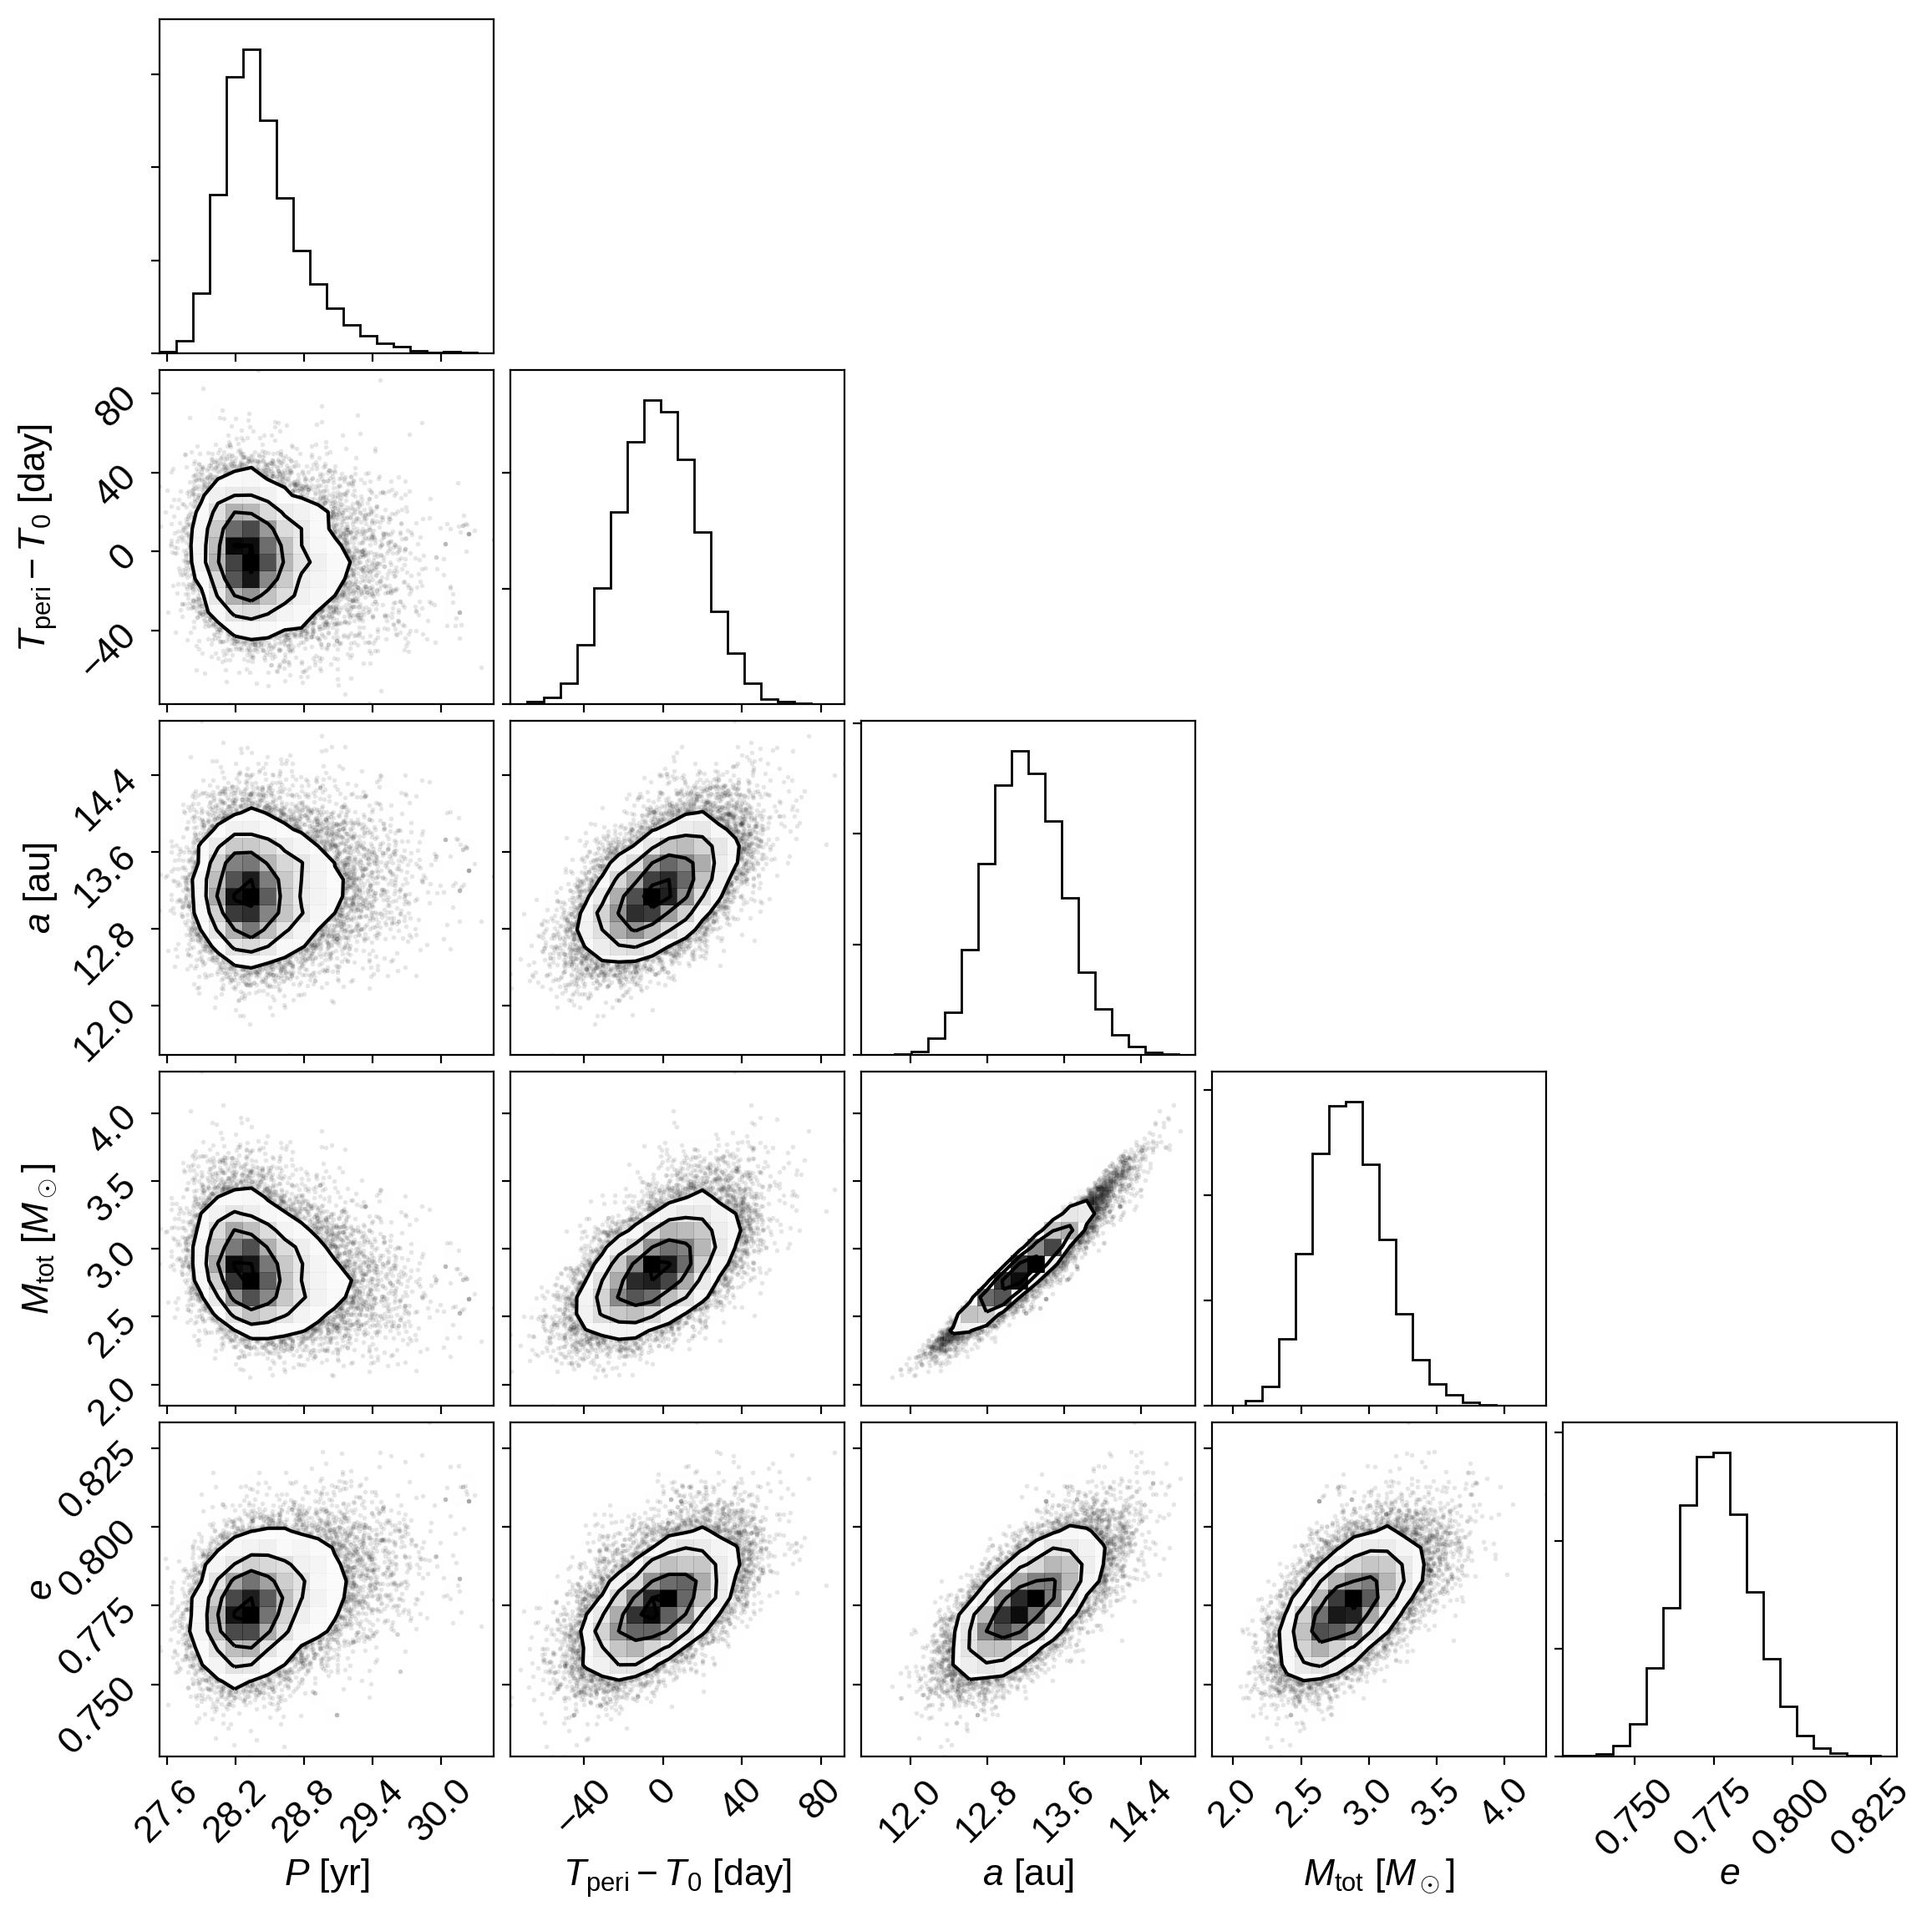

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
corner.corner(samples);

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
